# Synthetic Sleep Environment Dataset — Pipeline Visualization
**TECHIN 513: Signal Processing & Machine Learning | Team 7**
Rushav Dash & Lisa Li — University of Washington | 2026

---
This notebook walks through every stage of our pipeline with presentation-ready figures:

| Section | Content |
|---------|---------|
| 1 | Pipeline overview |
| 2 | Raw training data (real Kaggle datasets) |
| 3 | Signal generation |
| 4 | Untrained baseline vs. trained ML model |
| 5 | Final synthetic dataset |
| 6 | Validation summary |


## 0  Setup

In [1]:
import sys, os, json, warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = os.path.abspath(os.getcwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from src.data_loader import DataLoader
from src.signal_generator import SignalGenerator
from src.feature_extractor import extract_all_features
from src.sleep_quality_model import (
    SleepQualityModel, _encode_categoricals, _engineer_proxy_features
)

# ── global style ──────────────────────────────────────────────────────────────
PRES = {
    "figure.dpi": 130,
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.titleweight": "bold",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}
plt.rcParams.update(PRES)
sns.set_theme(style="whitegrid", rc=PRES)

SEASON_COLORS  = {"winter": "#5B9BD5", "spring": "#70AD47",
                  "summer": "#FF7043", "fall":   "#FFC000"}
AGE_COLORS     = {"young": "#5B9BD5", "middle": "#FF7043", "senior": "#70AD47"}
SIGNAL_COLORS  = {"temp": "#E74C3C", "light": "#F39C12",
                  "sound": "#9B59B6", "humidity": "#27AE60"}

print("Setup complete.")


Setup complete.


---
## 1  Pipeline Overview

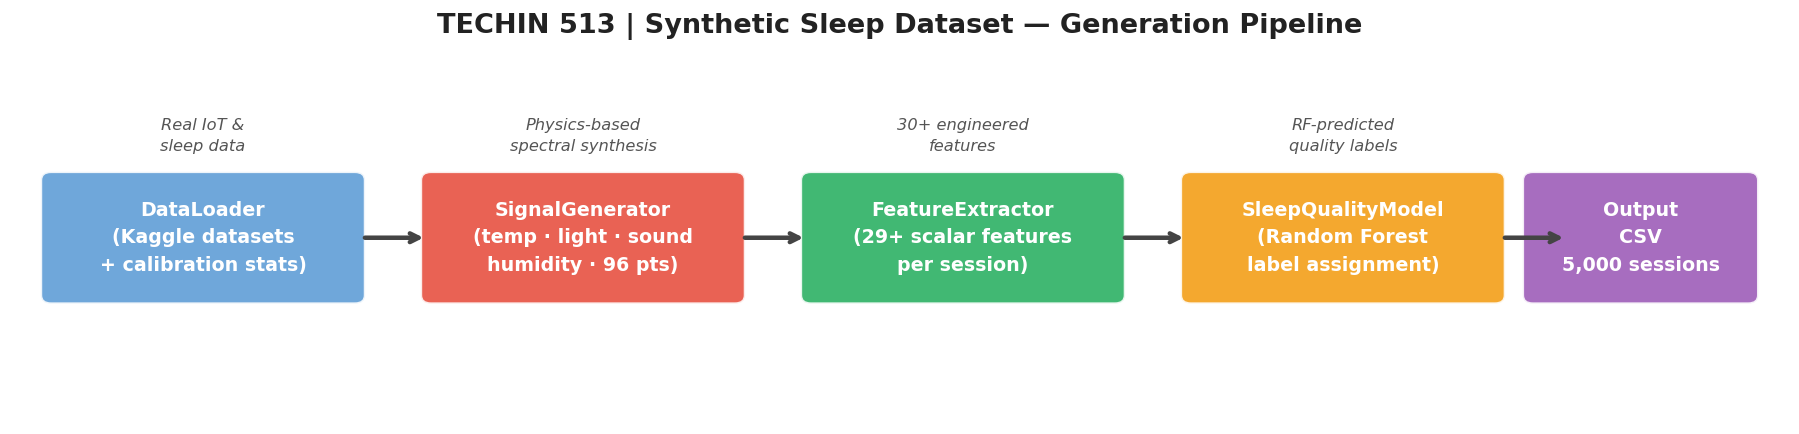

In [2]:
fig, ax = plt.subplots(figsize=(14, 3.5))
ax.set_xlim(0, 14)
ax.set_ylim(0, 3.5)
ax.axis("off")

BOXES = [
    (0.3,  1.2, 2.4, 1.1, "#5B9BD5", "DataLoader\n(Kaggle datasets\n+ calibration stats)"),
    (3.3,  1.2, 2.4, 1.1, "#E74C3C", "SignalGenerator\n(temp · light · sound\nhumidity · 96 pts)"),
    (6.3,  1.2, 2.4, 1.1, "#27AE60", "FeatureExtractor\n(29+ scalar features\nper session)"),
    (9.3,  1.2, 2.4, 1.1, "#F39C12", "SleepQualityModel\n(Random Forest\nlabel assignment)"),
    (12.0, 1.2, 1.7, 1.1, "#9B59B6", "Output\nCSV\n5,000 sessions"),
]

for (x, y, w, h, color, label) in BOXES:
    rect = mpatches.FancyBboxPatch((x, y), w, h,
        boxstyle="round,pad=0.08", linewidth=1.5,
        edgecolor="white", facecolor=color, alpha=0.88, zorder=2)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha="center", va="center",
            fontsize=10.5, color="white", fontweight="bold",
            zorder=3, linespacing=1.55)

# Arrows
for x_start in [2.75, 5.75, 8.75, 11.75]:
    ax.annotate("", xy=(x_start + 0.52, 1.75), xytext=(x_start, 1.75),
        arrowprops=dict(arrowstyle="->", lw=2.5, color="#444"))

# Labels above
labels_above = [
    (1.5,  "Real IoT &\nsleep data"),
    (4.5,  "Physics-based\nspectral synthesis"),
    (7.5,  "30+ engineered\nfeatures"),
    (10.5, "RF-predicted\nquality labels"),
]
for x, txt in labels_above:
    ax.text(x, 2.55, txt, ha="center", va="bottom",
            fontsize=9, color="#555", style="italic", linespacing=1.5)

ax.set_title("TECHIN 513 | Synthetic Sleep Dataset — Generation Pipeline",
             fontsize=15, fontweight="bold", pad=12, color="#222")
plt.tight_layout()
plt.savefig("pipeline_overview.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 2  Raw Training Data (Real Kaggle Datasets)

In [3]:
loader = DataLoader(verbose=False)
loader.download_all()
df_sleep = loader.load_sleep_efficiency()
df_occ   = loader.load_room_occupancy()
print(f"Sleep Efficiency: {df_sleep.shape[0]:,} rows × {df_sleep.shape[1]} cols")
print(f"Room Occupancy IoT: {df_occ.shape[0]:,} rows × {df_occ.shape[1]} cols")


Sleep Efficiency: 452 rows × 16 cols
Room Occupancy IoT: 20,560 rows × 8 cols


### 2a  Sleep Efficiency Dataset — Key Distributions

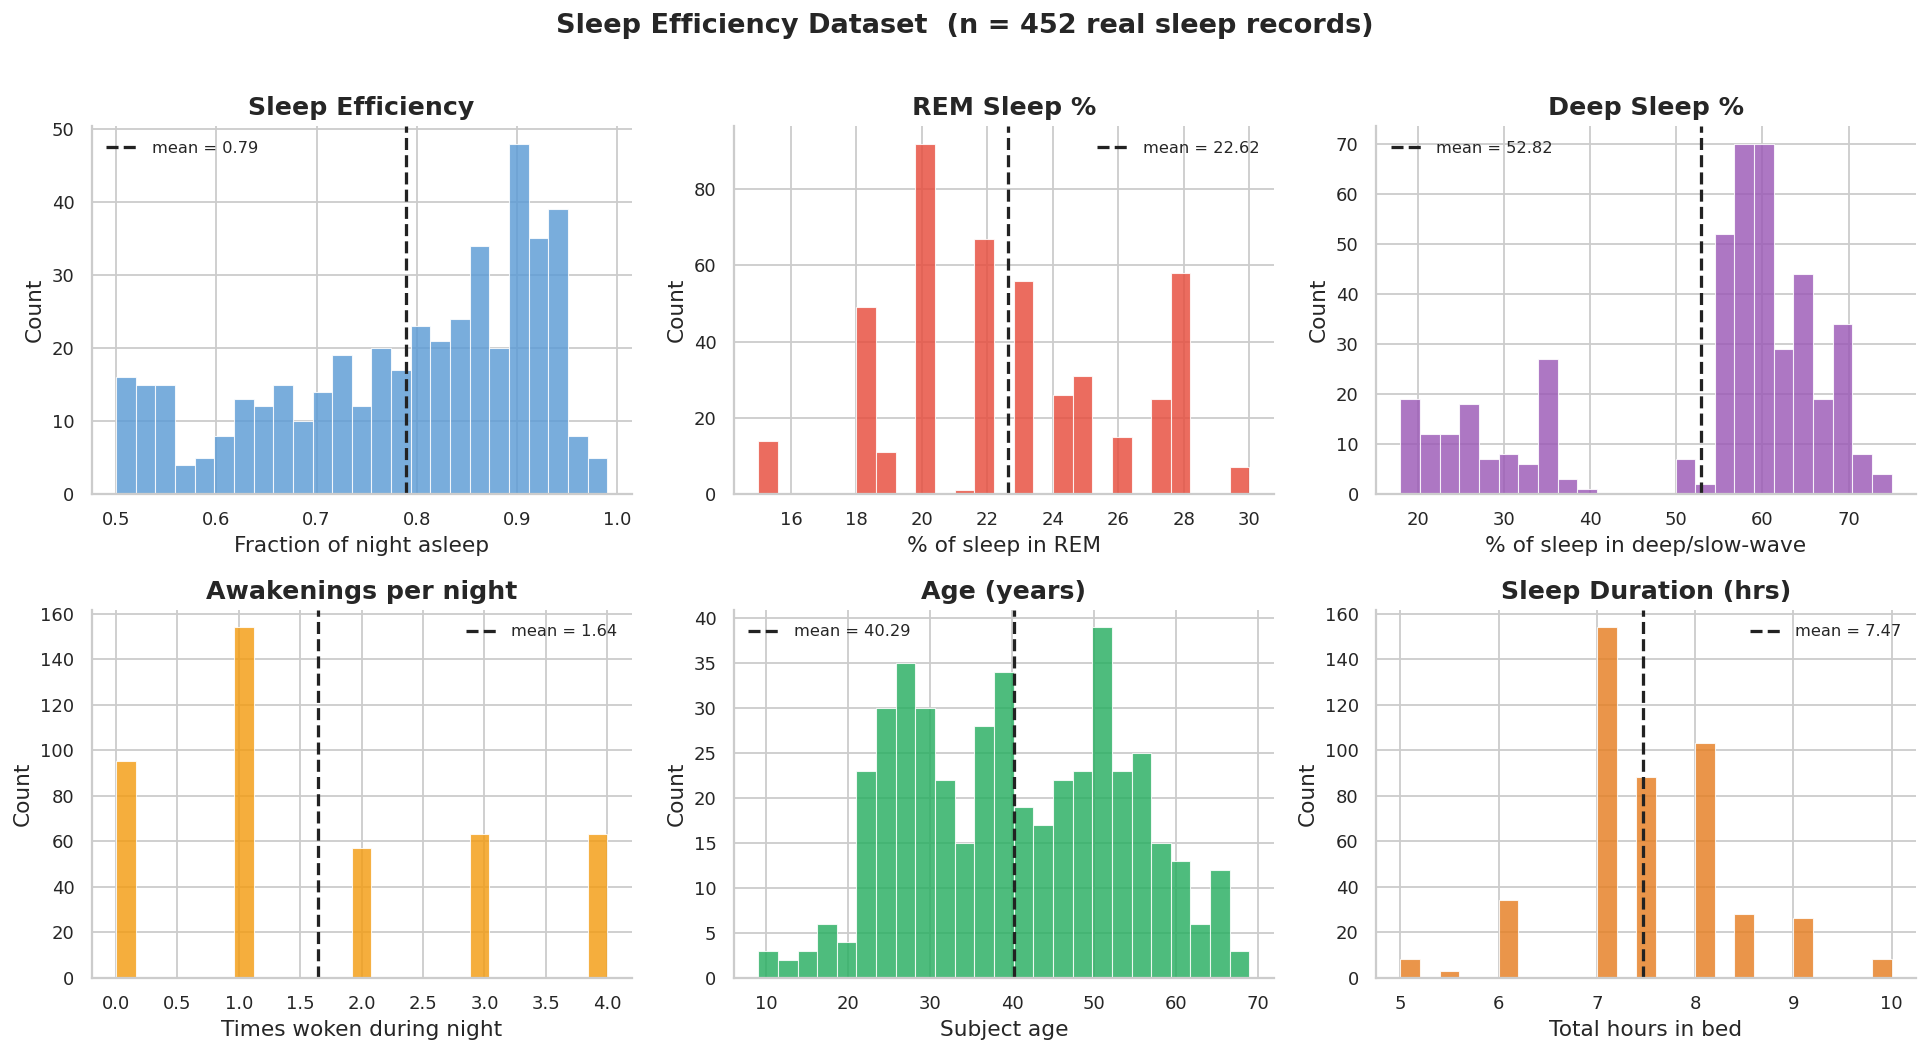

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Sleep Efficiency Dataset  (n = 452 real sleep records)",
             fontsize=15, fontweight="bold", y=1.01)

PLOTS = [
    ("Sleep efficiency",      "Sleep Efficiency",      "#5B9BD5", "Fraction of night asleep"),
    ("REM sleep percentage",  "REM Sleep %",           "#E74C3C", "% of sleep in REM"),
    ("Deep sleep percentage", "Deep Sleep %",          "#9B59B6", "% of sleep in deep/slow-wave"),
    ("Awakenings",            "Awakenings per night",  "#F39C12", "Times woken during night"),
    ("Age",                   "Age (years)",           "#27AE60", "Subject age"),
    ("Sleep duration",        "Sleep Duration (hrs)",  "#E67E22", "Total hours in bed"),
]

for ax, (col, title, color, note) in zip(axes.flatten(), PLOTS):
    data = df_sleep[col].dropna()
    ax.hist(data, bins=25, color=color, alpha=0.82, edgecolor="white", linewidth=0.6)
    ax.axvline(data.mean(), color="#222", lw=1.8, linestyle="--", label=f"mean = {data.mean():.2f}")
    ax.set_title(title)
    ax.set_xlabel(note)
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig("raw_sleep_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


### 2b  Room Occupancy IoT Sensor — Nighttime Measurements

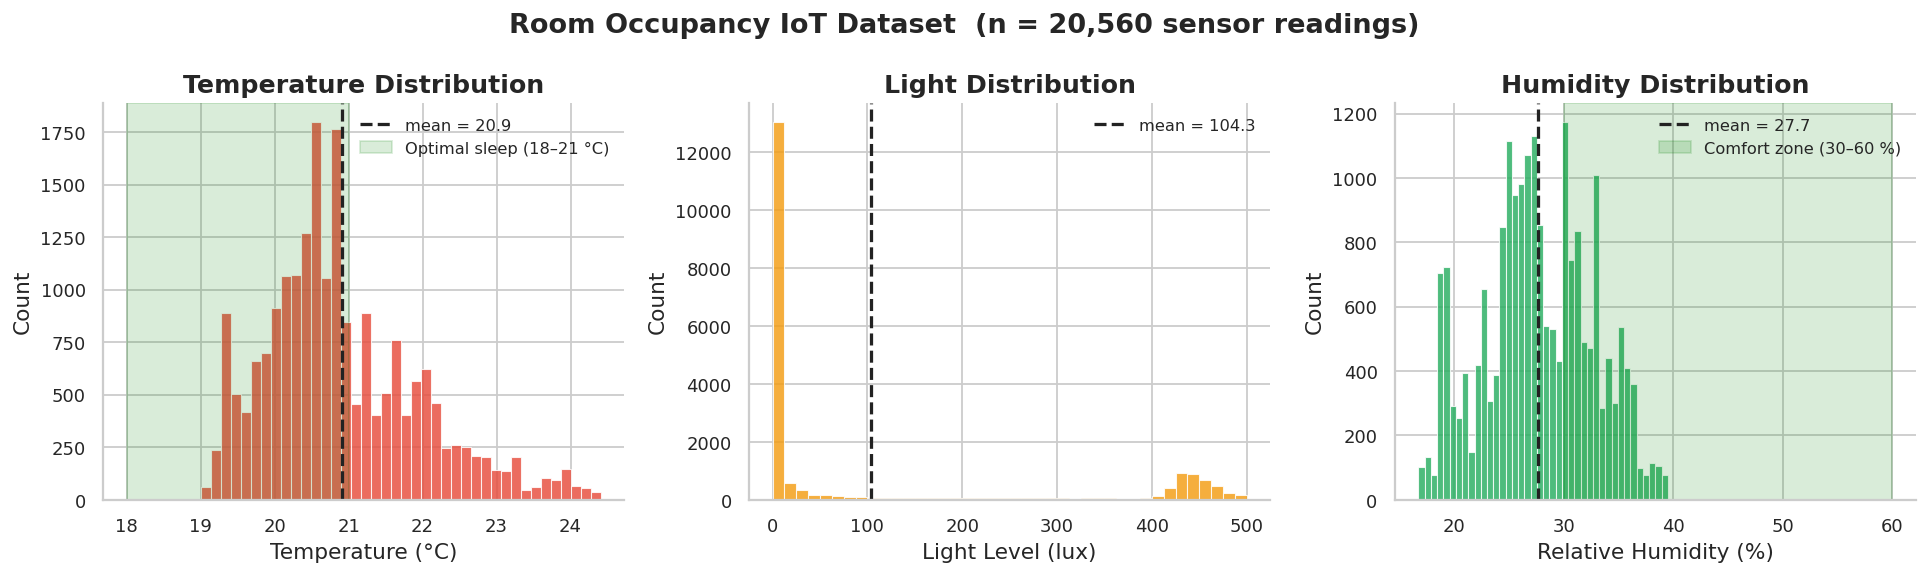

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
fig.suptitle("Room Occupancy IoT Dataset  (n = 20,560 sensor readings)",
             fontsize=15, fontweight="bold")

IOT_PLOTS = [
    ("Temperature", "Temperature (°C)",      "#E74C3C", [15, 32]),
    ("Light",       "Light Level (lux)",     "#F39C12", [0, 500]),
    ("Humidity",    "Relative Humidity (%)", "#27AE60", [0, 100]),
]

for ax, (col, xlabel, color, xlim) in zip(axes, IOT_PLOTS):
    if col not in df_occ.columns:
        ax.text(0.5, 0.5, f"{col} not in dataset", ha="center", transform=ax.transAxes)
        continue
    data = df_occ[col].dropna()
    data = data[(data >= xlim[0]) & (data <= xlim[1])]
    ax.hist(data, bins=40, color=color, alpha=0.82, edgecolor="white", linewidth=0.6)
    ax.axvline(data.mean(), color="#222", lw=1.8, linestyle="--",
               label=f"mean = {data.mean():.1f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.set_title(f"{col} Distribution")
    ax.legend(fontsize=9)

# Mark optimal sleep zones
axes[0].axvspan(18, 21, alpha=0.15, color="green", label="Optimal sleep (18–21 °C)")
axes[0].legend(fontsize=9)
axes[2].axvspan(30, 60, alpha=0.15, color="green", label="Comfort zone (30–60 %)")
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.savefig("raw_iot_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


### 2c  Sleep Efficiency Correlation Map

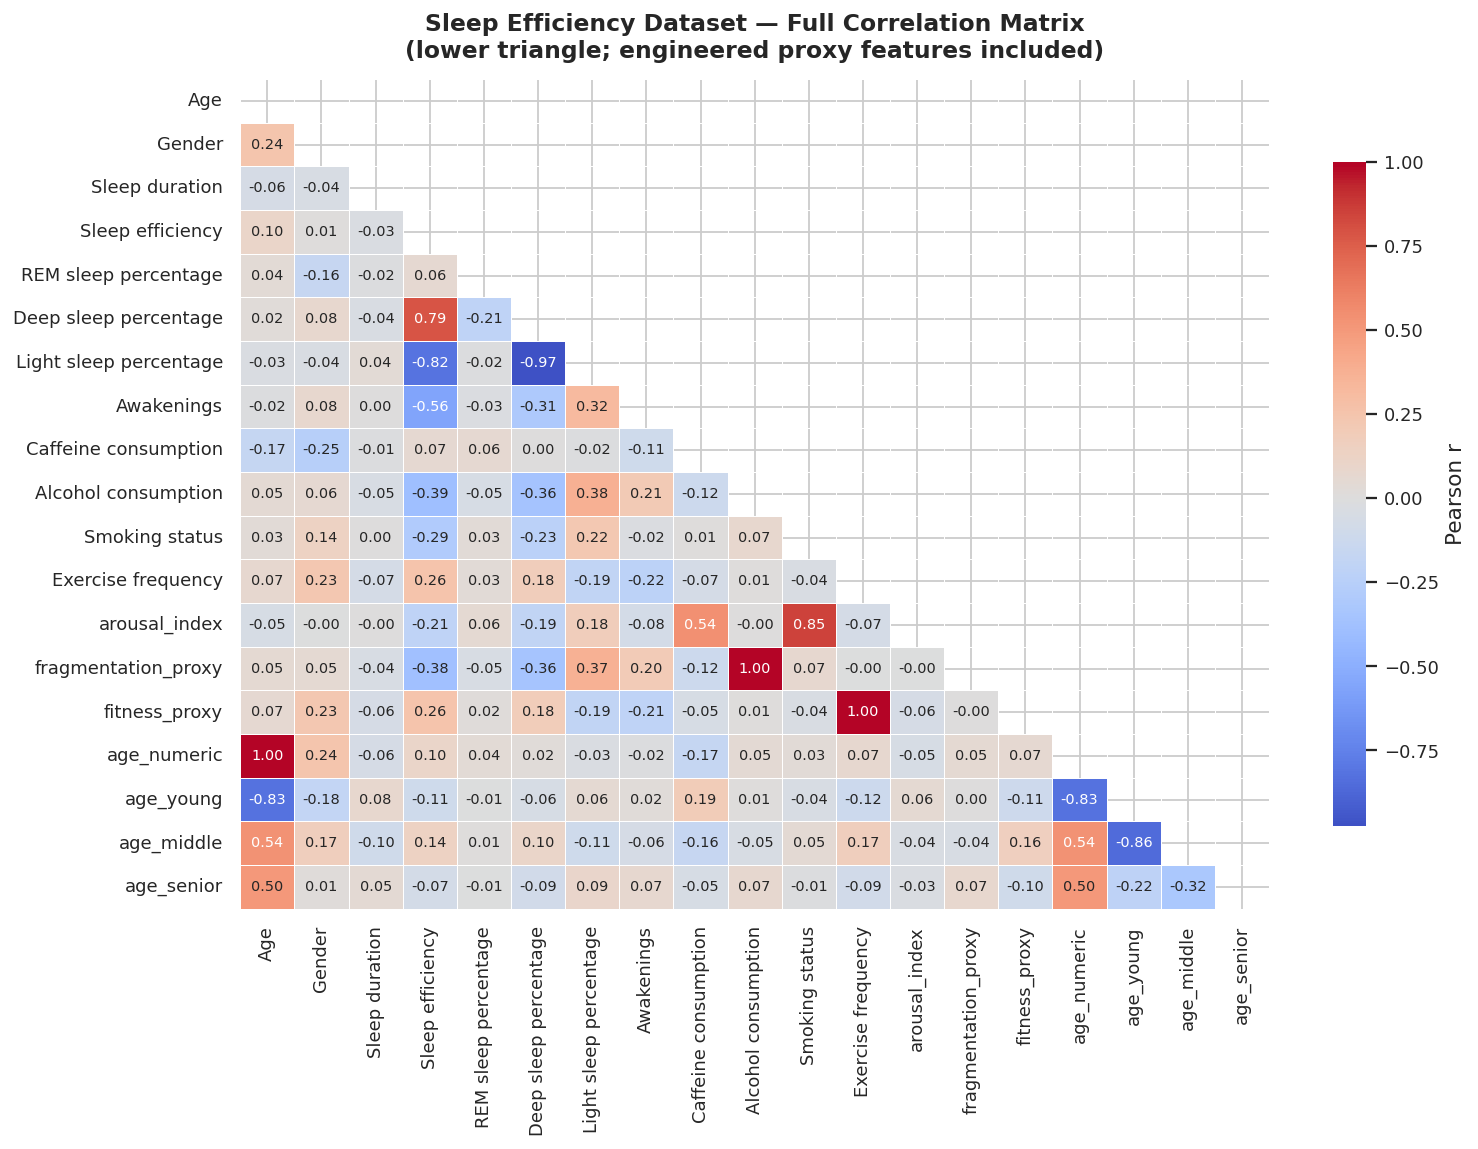

In [6]:
num_df = _engineer_proxy_features(_encode_categoricals(df_sleep.copy())).select_dtypes(include="number")
corr = num_df.corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", center=0, linewidths=0.4,
    annot_kws={"size": 8}, ax=ax,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"}
)
ax.set_title("Sleep Efficiency Dataset — Full Correlation Matrix\n"
             "(lower triangle; engineered proxy features included)",
             fontsize=13, pad=12)
plt.tight_layout()
plt.savefig("raw_correlation_matrix.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 3  Signal Generation
Physics-based spectral synthesis for all four environmental modalities.

In [7]:
ref_stats = loader.extract_reference_stats()

# Generate one sample session per season
SEASONS = ["winter", "spring", "summer", "fall"]
sg = SignalGenerator(ref_stats=ref_stats)
sessions = {}
for i, season in enumerate(SEASONS):
    sessions[season] = sg.generate_all(
        season=season, age_group="middle", sensitivity="normal", random_seed=42 + i
    )

t = np.arange(96) * 5  # time axis in minutes (0 – 475)
print("Sample sessions generated.")


Sample sessions generated.


### 3a  All Four Signals — One Representative Night (Summer)

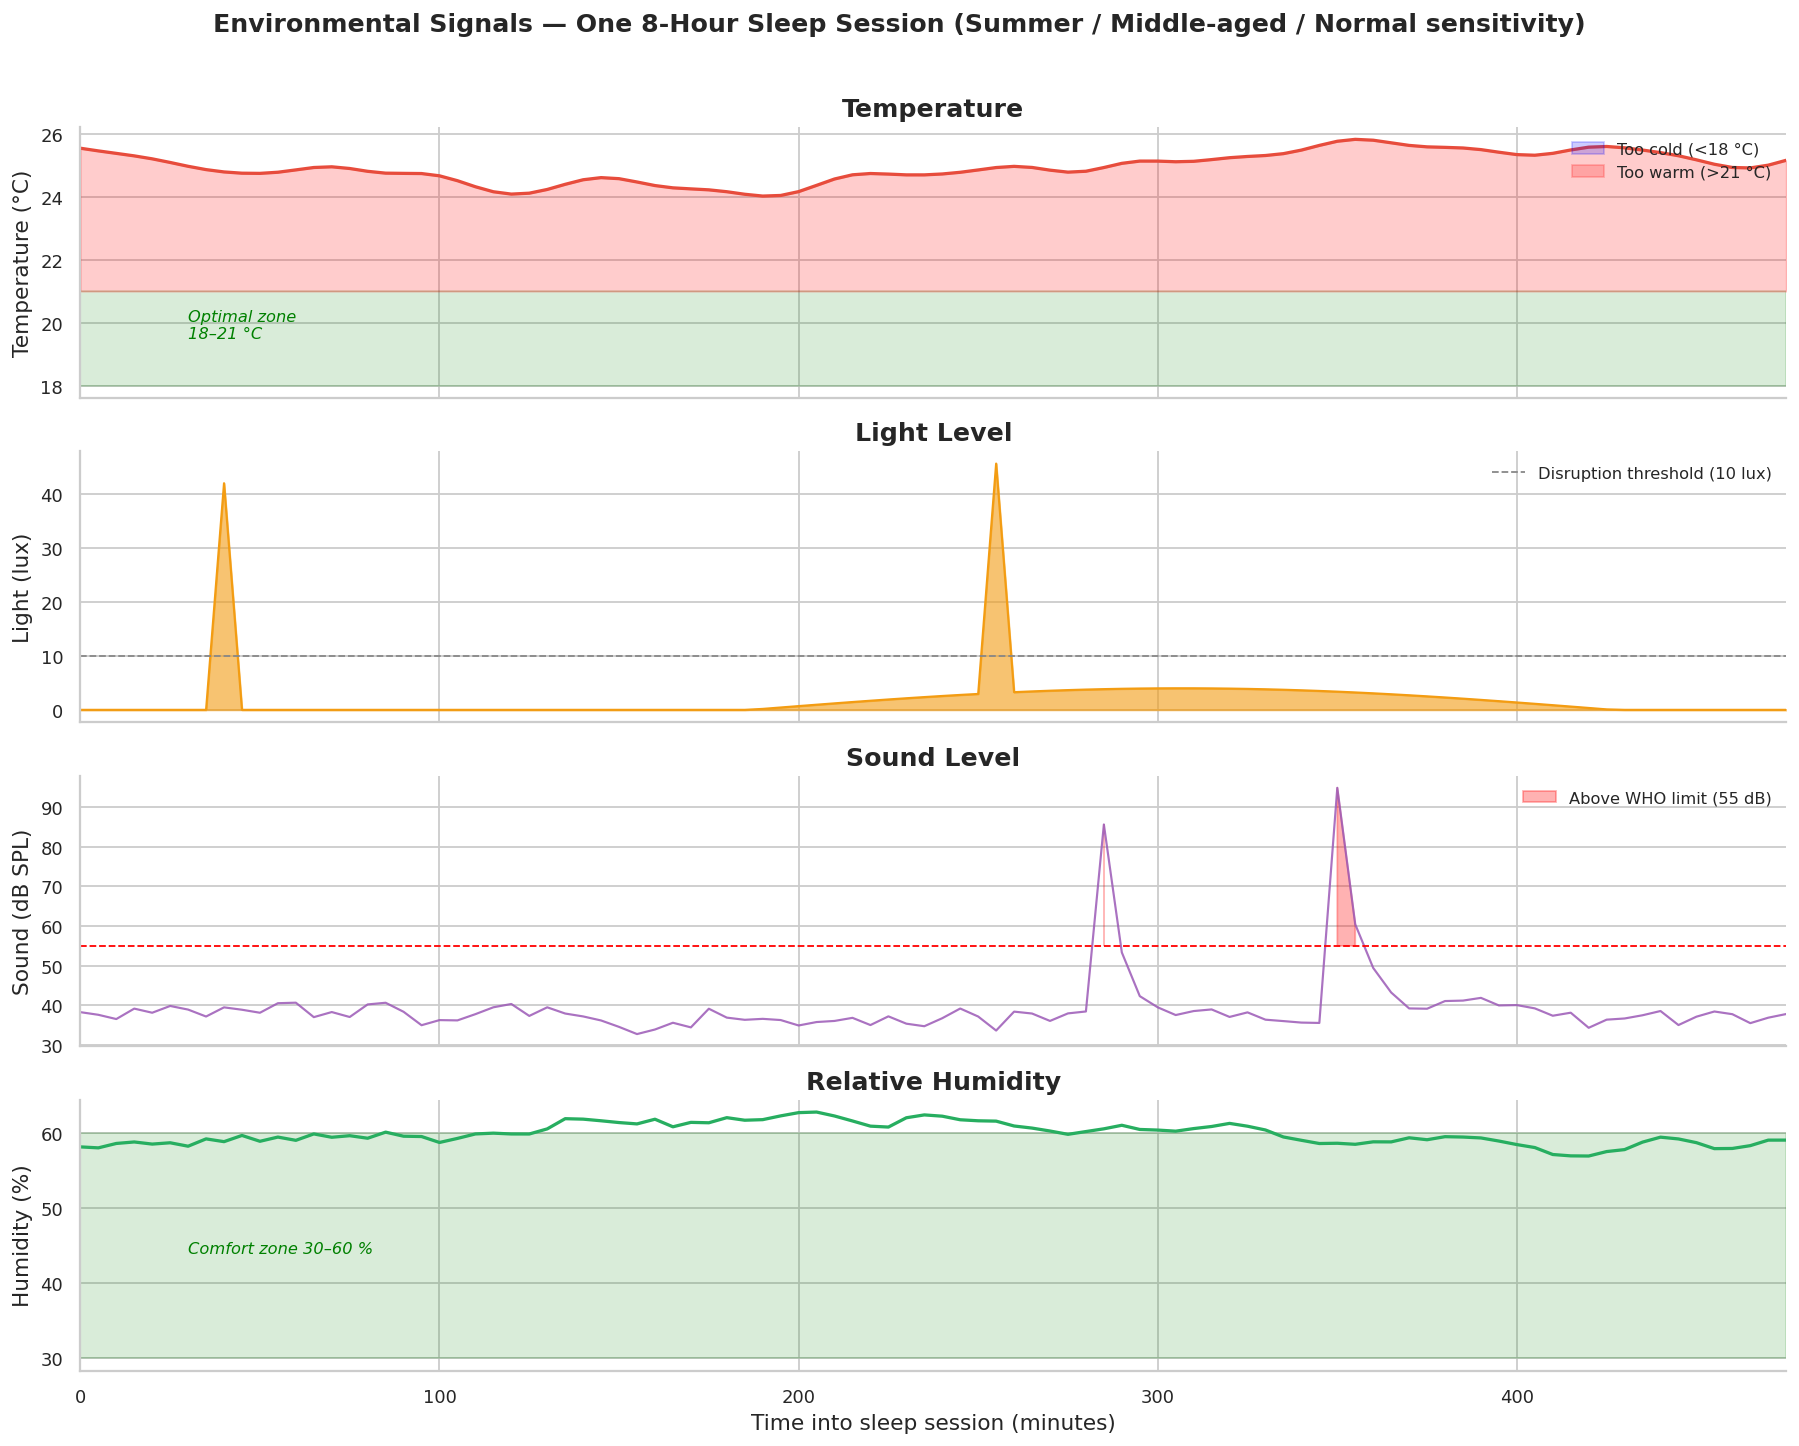

In [8]:
sess = sessions["summer"]
fig, axes = plt.subplots(4, 1, figsize=(14, 11), sharex=True)
fig.suptitle("Environmental Signals — One 8-Hour Sleep Session (Summer / Middle-aged / Normal sensitivity)",
             fontsize=14, fontweight="bold", y=1.01)

# Temperature
ax = axes[0]
ax.plot(t, sess["temperature"], color=SIGNAL_COLORS["temp"], lw=1.8)
ax.axhspan(18, 21, alpha=0.15, color="green")
ax.fill_between(t, sess["temperature"], 18, where=np.array(sess["temperature"]) < 18,
                alpha=0.2, color="blue", label="Too cold (<18 °C)")
ax.fill_between(t, sess["temperature"], 21, where=np.array(sess["temperature"]) > 21,
                alpha=0.2, color="red", label="Too warm (>21 °C)")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Temperature")
ax.legend(fontsize=9, loc="upper right")
ax.annotate("Optimal zone\n18–21 °C", xy=(30, 19.5), fontsize=9, color="green", style="italic")

# Light
ax = axes[1]
ax.fill_between(t, sess["light"], alpha=0.6, color=SIGNAL_COLORS["light"])
ax.plot(t, sess["light"], color=SIGNAL_COLORS["light"], lw=1.2)
ax.axhline(10, color="#888", lw=1, linestyle="--", label="Disruption threshold (10 lux)")
ax.set_ylabel("Light (lux)")
ax.set_title("Light Level")
ax.legend(fontsize=9)

# Sound
ax = axes[2]
ax.plot(t, sess["sound"], color=SIGNAL_COLORS["sound"], lw=1.2, alpha=0.85)
ax.fill_between(t, 55, sess["sound"], where=np.array(sess["sound"]) > 55,
                alpha=0.3, color="red", label="Above WHO limit (55 dB)")
ax.axhline(55, color="red", lw=1, linestyle="--")
ax.set_ylabel("Sound (dB SPL)")
ax.set_title("Sound Level")
ax.legend(fontsize=9)

# Humidity
ax = axes[3]
ax.plot(t, sess["humidity"], color=SIGNAL_COLORS["humidity"], lw=1.8)
ax.axhspan(30, 60, alpha=0.15, color="green")
ax.set_ylabel("Humidity (%)")
ax.set_xlabel("Time into sleep session (minutes)")
ax.set_title("Relative Humidity")
ax.annotate("Comfort zone 30–60 %", xy=(30, 44), fontsize=9, color="green", style="italic")

for a in axes:
    a.set_xlim(0, 475)

plt.tight_layout()
plt.savefig("signals_one_session.png", dpi=150, bbox_inches="tight")
plt.show()


### 3b  Seasonal Diversity — Temperature Signals

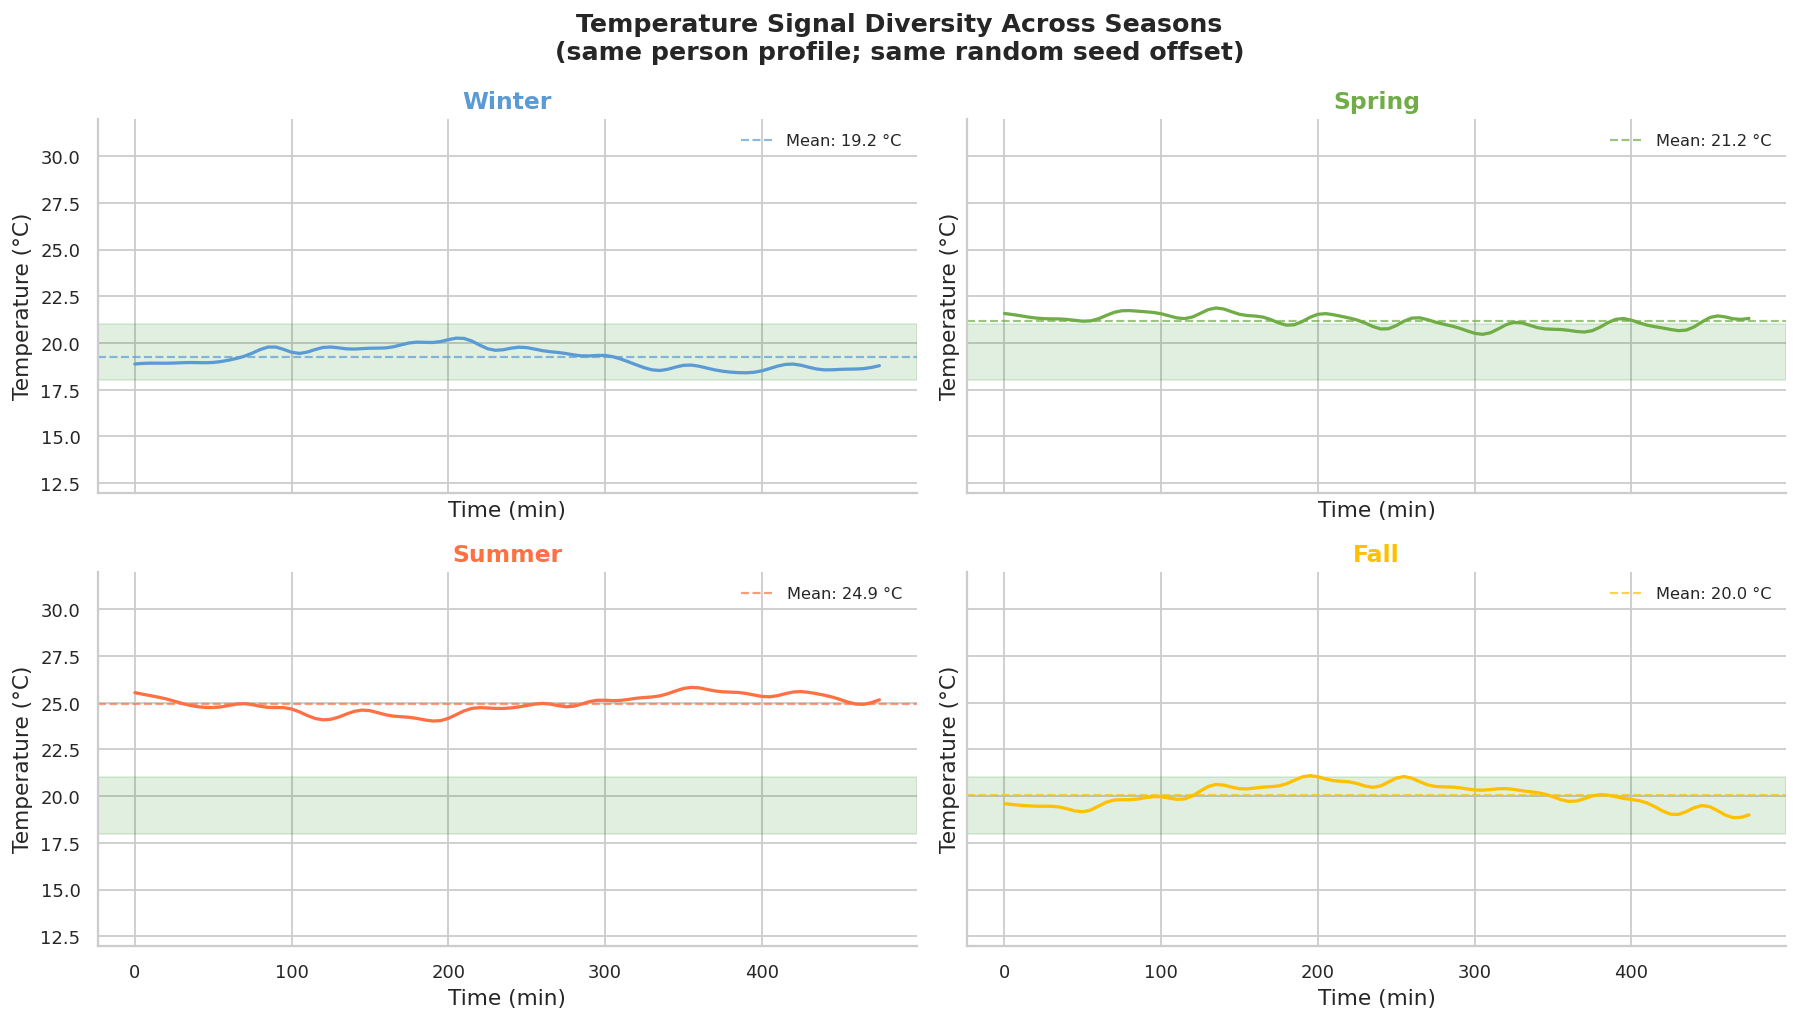

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Temperature Signal Diversity Across Seasons\n"
             "(same person profile; same random seed offset)",
             fontsize=14, fontweight="bold")

for ax, season in zip(axes.flatten(), SEASONS):
    color = SEASON_COLORS[season]
    ax.plot(t, sessions[season]["temperature"], color=color, lw=1.8)
    ax.axhspan(18, 21, alpha=0.12, color="green")
    ax.set_ylim(12, 32)
    ax.set_title(season.capitalize(), color=color, fontsize=13)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Temperature (°C)")

    mean_t = np.mean(sessions[season]["temperature"])
    ax.axhline(mean_t, color=color, lw=1.2, linestyle="--", alpha=0.7,
               label=f"Mean: {mean_t:.1f} °C")
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig("signals_seasonal_temperature.png", dpi=150, bbox_inches="tight")
plt.show()


### 3c  Feature Extraction — From Time Series to Scalar Features

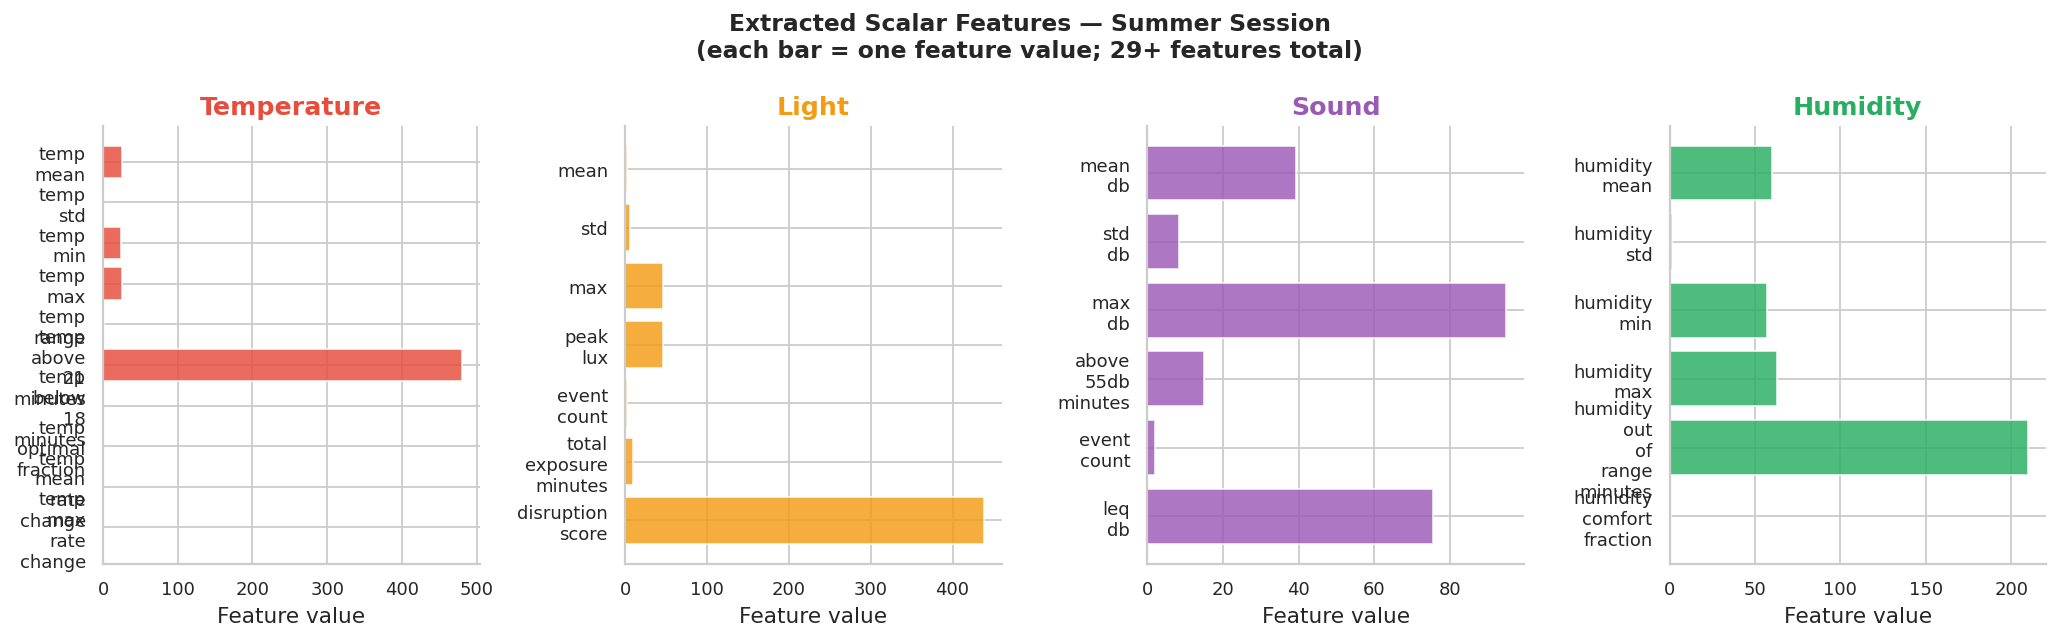

In [10]:
feats = extract_all_features(signals=sessions["summer"])

# Organize into groups for display
groups = {
    "Temperature": {k: v for k, v in feats.items() if k.startswith("temp_")},
    "Light":       {k: v for k, v in feats.items() if k.startswith("light_")},
    "Sound":       {k: v for k, v in feats.items() if k.startswith("sound_")},
    "Humidity":    {k: v for k, v in feats.items() if k.startswith("humidity_")},
}

fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle("Extracted Scalar Features — Summer Session\n"
             "(each bar = one feature value; 29+ features total)",
             fontsize=13, fontweight="bold")

group_colors = {"Temperature": SIGNAL_COLORS["temp"], "Light": SIGNAL_COLORS["light"],
                "Sound": SIGNAL_COLORS["sound"], "Humidity": SIGNAL_COLORS["humidity"]}

for ax, (group, fdict) in zip(axes, groups.items()):
    names = [k.replace(group.lower()[:5] + "_", "").replace("_", "\n") for k in fdict]
    vals  = list(fdict.values())
    bars  = ax.barh(names, vals, color=group_colors[group], alpha=0.82, edgecolor="white")
    ax.set_title(group, color=group_colors[group])
    ax.set_xlabel("Feature value")
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig("feature_extraction.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 4  Untrained Baseline vs. Trained Random Forest
We show how much the ML model adds over a naïve mean predictor.

In [11]:
# ── Prepare training data ──────────────────────────────────────────────────
df_enc = _engineer_proxy_features(_encode_categoricals(df_sleep.copy()))
targets = ["Sleep efficiency", "Awakenings", "REM sleep percentage", "Deep sleep percentage"]
targets = [t for t in targets if t in df_enc.columns]
df_enc = df_enc.dropna(subset=targets)

feat_cols = [c for c in df_enc.select_dtypes(include="number").columns
             if c not in targets + ["ID", "id"]]
X = df_enc[feat_cols].fillna(df_enc[feat_cols].median())

# ── Cross-validate: Baseline (mean) vs RF ─────────────────────────────────
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for target in targets:
    y = df_enc[target].values

    dummy = DummyRegressor(strategy="mean")
    rf    = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

    dummy_rmse = (-cross_val_score(dummy, X, y, cv=kf,
                                   scoring="neg_root_mean_squared_error")).mean()
    rf_rmse    = (-cross_val_score(rf,    X, y, cv=kf,
                                   scoring="neg_root_mean_squared_error")).mean()
    dummy_r2   = cross_val_score(dummy, X, y, cv=kf, scoring="r2").mean()
    rf_r2      = cross_val_score(rf,    X, y, cv=kf, scoring="r2").mean()

    results.append({"target": target.replace(" percentage", " %"),
                    "baseline_rmse": dummy_rmse, "rf_rmse": rf_rmse,
                    "baseline_r2": max(dummy_r2, 0), "rf_r2": max(rf_r2, 0)})

df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))


          target  baseline_rmse  rf_rmse  baseline_r2    rf_r2
Sleep efficiency       0.135694 0.068994            0 0.728037
      Awakenings       1.357685 1.335815            0 0.009265
     REM sleep %       3.551983 2.938148            0 0.314186
    Deep sleep %      15.592718 2.986742            0 0.962674


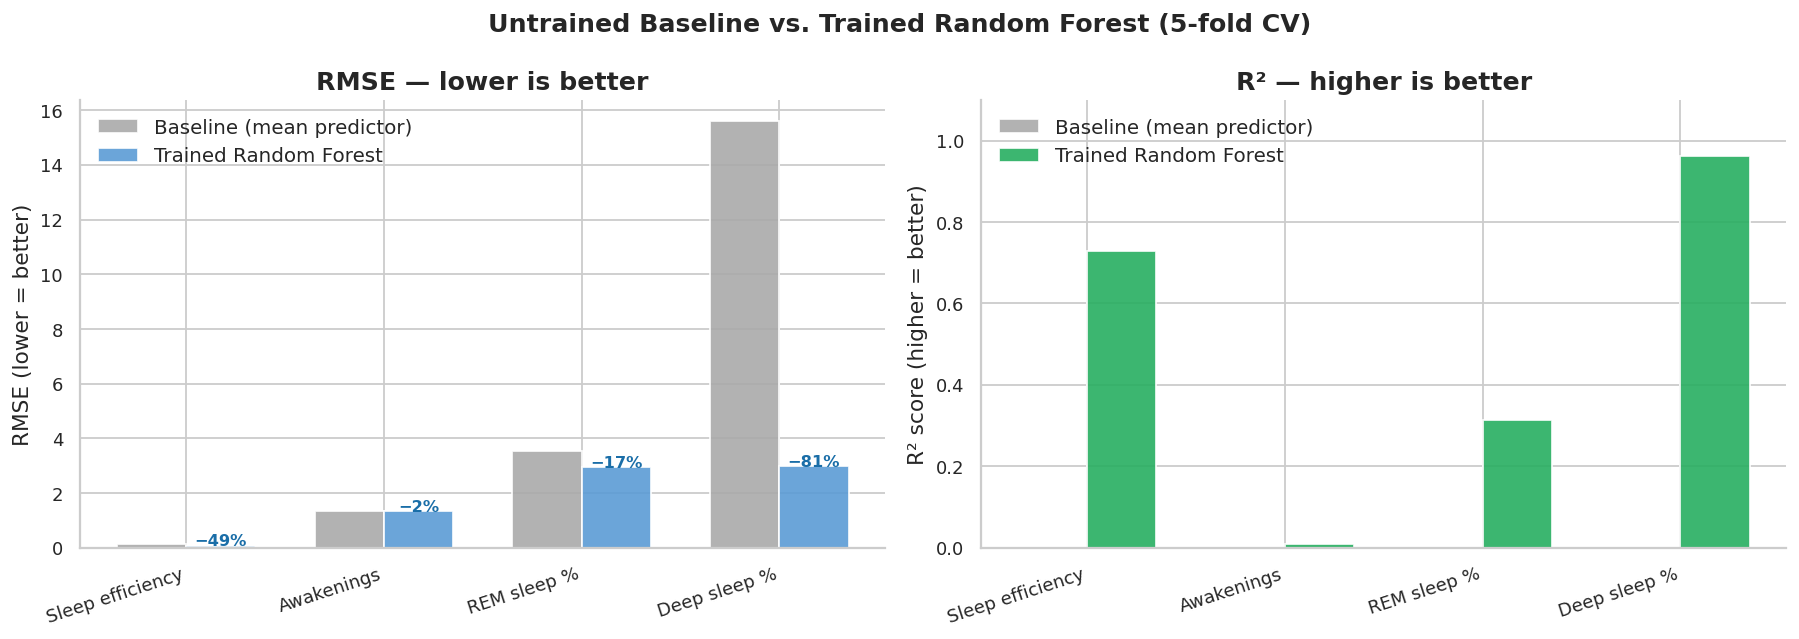

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Untrained Baseline vs. Trained Random Forest (5-fold CV)",
             fontsize=14, fontweight="bold")

x = np.arange(len(df_res))
w = 0.35
labels = df_res["target"].tolist()

# RMSE
ax = axes[0]
ax.bar(x - w/2, df_res["baseline_rmse"], w, label="Baseline (mean predictor)",
       color="#AAAAAA", edgecolor="white", alpha=0.9)
ax.bar(x + w/2, df_res["rf_rmse"],       w, label="Trained Random Forest",
       color="#5B9BD5", edgecolor="white", alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=18, ha="right")
ax.set_ylabel("RMSE (lower = better)")
ax.set_title("RMSE — lower is better")
ax.legend()

for xi, (b, r) in enumerate(zip(df_res["baseline_rmse"], df_res["rf_rmse"])):
    pct = (b - r) / b * 100
    ax.text(xi + w/2, r + 0.002, f"−{pct:.0f}%", ha="center", fontsize=9,
            color="#1a6ea8", fontweight="bold")

# R²
ax = axes[1]
ax.bar(x - w/2, df_res["baseline_r2"], w, label="Baseline (mean predictor)",
       color="#AAAAAA", edgecolor="white", alpha=0.9)
ax.bar(x + w/2, df_res["rf_r2"],       w, label="Trained Random Forest",
       color="#27AE60", edgecolor="white", alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=18, ha="right")
ax.set_ylabel("R² score (higher = better)")
ax.set_title("R² — higher is better")
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.savefig("model_baseline_vs_trained.png", dpi=150, bbox_inches="tight")
plt.show()


### 4b  Feature Importance — What Drives Sleep Efficiency?

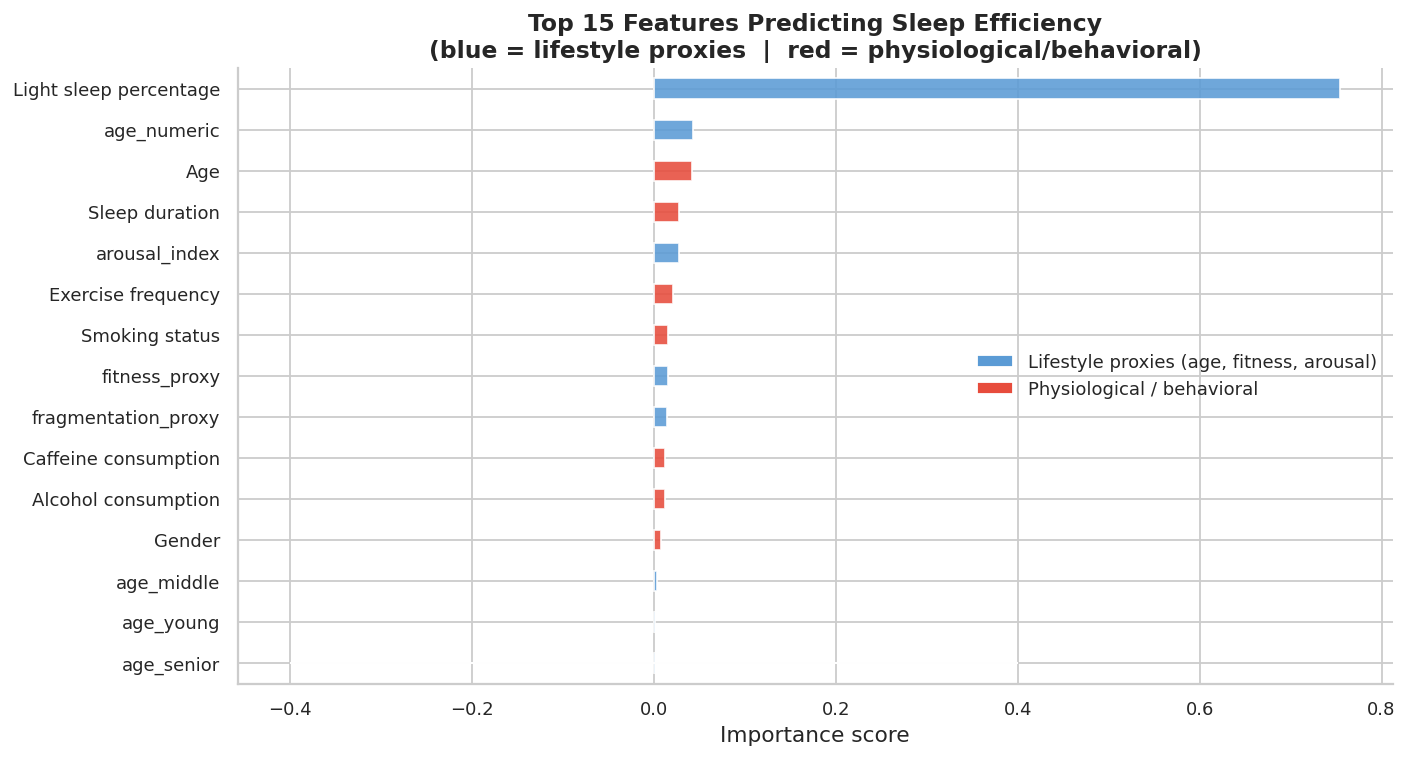

In [13]:
rf_final = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_final.fit(X, df_enc["Sleep efficiency"].values)

fi = pd.Series(rf_final.feature_importances_, index=feat_cols).sort_values(ascending=True)
top = fi.tail(15)

fig, ax = plt.subplots(figsize=(11, 6))
colors = ["#5B9BD5" if "age" in n or "fitness" in n or "arousal" in n or "frag" in n
          else "#E74C3C" for n in top.index]
top.plot.barh(ax=ax, color=colors, edgecolor="white", alpha=0.88)
ax.set_xlabel("Importance score")
ax.set_title("Top 15 Features Predicting Sleep Efficiency\n"
             "(blue = lifestyle proxies  |  red = physiological/behavioral)",
             fontsize=13)

# Legend
ax.bar(0, 0, color="#5B9BD5", label="Lifestyle proxies (age, fitness, arousal)")
ax.bar(0, 0, color="#E74C3C", label="Physiological / behavioral")
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()


### 4c  Predicted vs Actual — Trained Model (Sleep Efficiency)

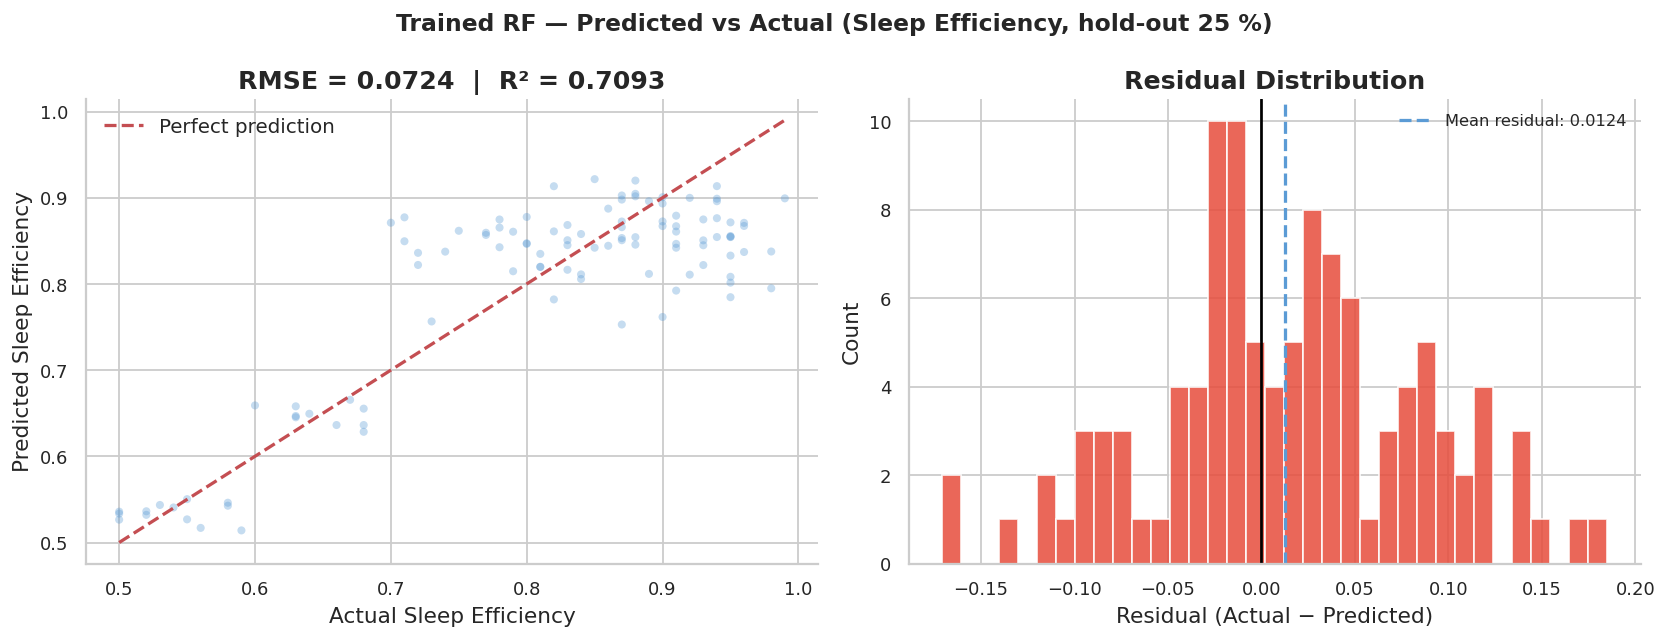

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, df_enc["Sleep efficiency"].values, test_size=0.25, random_state=42)

rf_cv = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_cv.fit(X_tr, y_tr)
y_pred = rf_cv.predict(X_te)
residuals = y_te - y_pred

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Trained RF — Predicted vs Actual (Sleep Efficiency, hold-out 25 %)",
             fontsize=13, fontweight="bold")

# Scatter
ax = axes[0]
ax.scatter(y_te, y_pred, alpha=0.35, s=20, color="#5B9BD5", edgecolors="none")
lo, hi = min(y_te.min(), y_pred.min()), max(y_te.max(), y_pred.max())
ax.plot([lo, hi], [lo, hi], "r--", lw=1.8, label="Perfect prediction")
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
r2   = r2_score(y_te, y_pred)
ax.set_xlabel("Actual Sleep Efficiency")
ax.set_ylabel("Predicted Sleep Efficiency")
ax.set_title(f"RMSE = {rmse:.4f}  |  R² = {r2:.4f}")
ax.legend()

# Residuals
ax = axes[1]
ax.hist(residuals, bins=35, color="#E74C3C", edgecolor="white", alpha=0.85)
ax.axvline(0, color="black", lw=1.5)
ax.axvline(residuals.mean(), color="#5B9BD5", lw=1.8, linestyle="--",
           label=f"Mean residual: {residuals.mean():.4f}")
ax.set_xlabel("Residual (Actual − Predicted)")
ax.set_ylabel("Count")
ax.set_title("Residual Distribution")
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig("model_predicted_vs_actual.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 5  Final Synthetic Dataset (5,000 Sessions)

In [15]:
CSV = os.path.join(PROJECT_ROOT, "data", "output", "synthetic_sleep_dataset_5000.csv")
df = pd.read_csv(CSV)
TS_COLS    = [c for c in df.columns if c.startswith("ts_")]
META_COLS  = ["session_id","session_index","season","age_group","sensitivity","random_seed"]
LABEL_COLS = ["sleep_efficiency","awakenings","rem_pct","deep_pct","light_pct"]
FEAT_COLS  = [c for c in df.columns if c not in TS_COLS + META_COLS + LABEL_COLS]

print(f"Dataset: {len(df):,} sessions  ×  {len(df.columns)} columns")
print(f"Feature columns: {len(FEAT_COLS)}  |  TS columns: {len(TS_COLS)}")
df[META_COLS[2:5] + LABEL_COLS].head(3)


Dataset: 5,000 sessions  ×  44 columns
Feature columns: 29  |  TS columns: 4


,season,age_group,sensitivity,sleep_efficiency,awakenings,rem_pct,deep_pct,light_pct
0,winter,young,low,0.7460,3,17.3,70.3,12.4
1,winter,young,normal,0.7233,2,19.9,68.6,11.5
2,winter,young,high,0.9188,1,18.7,71.1,10.2


### 5a  Dataset Stratification

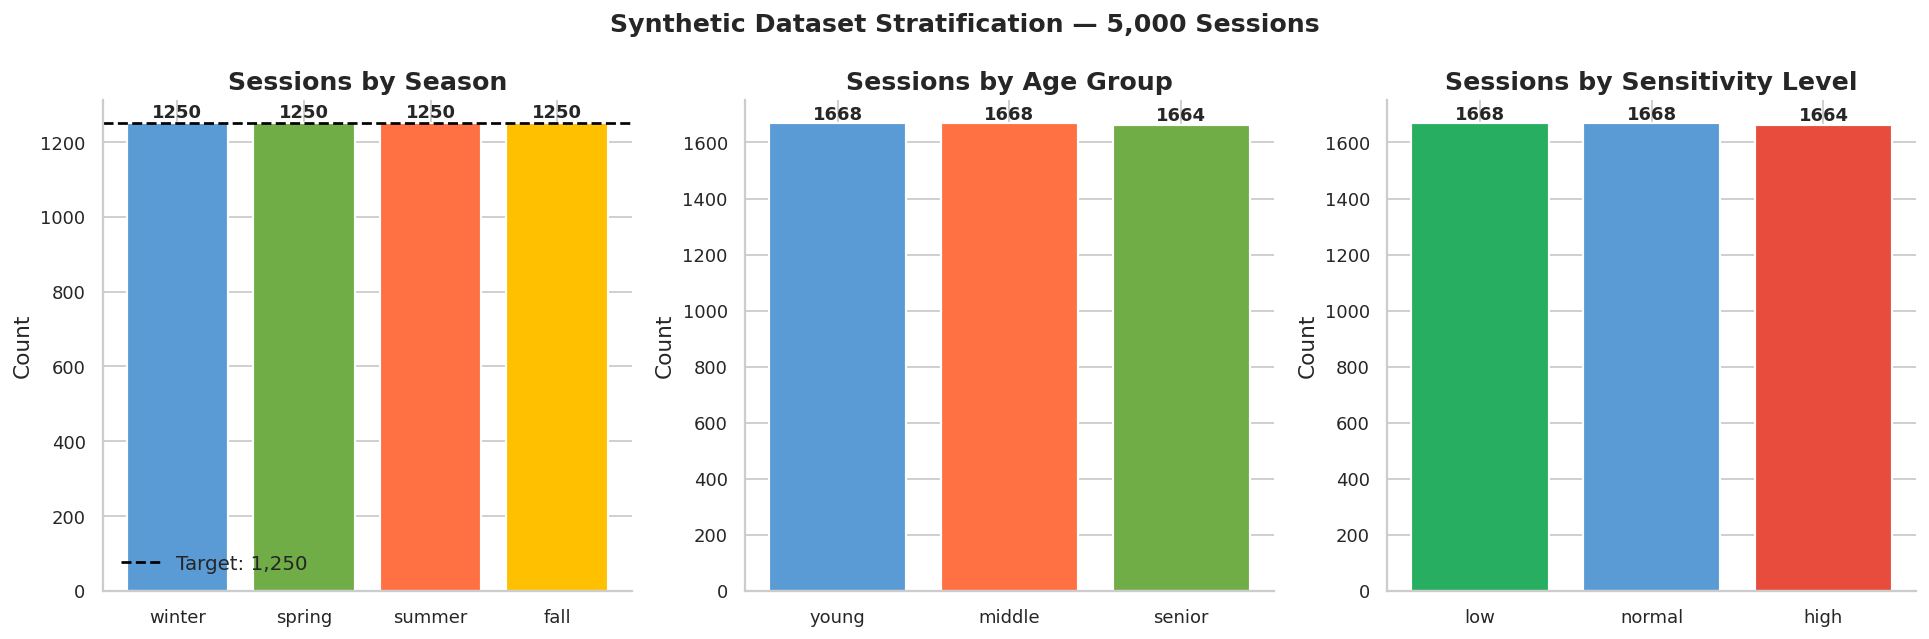

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Synthetic Dataset Stratification — 5,000 Sessions",
             fontsize=14, fontweight="bold")

# Season
season_counts = df["season"].value_counts().reindex(["winter","spring","summer","fall"])
axes[0].bar(season_counts.index, season_counts.values,
            color=[SEASON_COLORS[s] for s in season_counts.index],
            edgecolor="white", linewidth=1.2)
axes[0].axhline(1250, color="black", lw=1.5, linestyle="--", label="Target: 1,250")
axes[0].set_title("Sessions by Season")
axes[0].set_ylabel("Count")
axes[0].legend()
for i, (s, v) in enumerate(season_counts.items()):
    axes[0].text(i, v + 15, str(v), ha="center", fontsize=10, fontweight="bold")

# Age group
age_counts = df["age_group"].value_counts().reindex(["young","middle","senior"])
axes[1].bar(age_counts.index, age_counts.values,
            color=[AGE_COLORS[a] for a in age_counts.index],
            edgecolor="white", linewidth=1.2)
axes[1].set_title("Sessions by Age Group")
axes[1].set_ylabel("Count")
for i, (a, v) in enumerate(age_counts.items()):
    axes[1].text(i, v + 15, str(v), ha="center", fontsize=10, fontweight="bold")

# Sensitivity
sens_counts = df["sensitivity"].value_counts().reindex(["low","normal","high"])
SENS_COLORS = {"low": "#27AE60", "normal": "#5B9BD5", "high": "#E74C3C"}
axes[2].bar(sens_counts.index, sens_counts.values,
            color=[SENS_COLORS[s] for s in sens_counts.index],
            edgecolor="white", linewidth=1.2)
axes[2].set_title("Sessions by Sensitivity Level")
axes[2].set_ylabel("Count")
for i, (s, v) in enumerate(sens_counts.items()):
    axes[2].text(i, v + 15, str(v), ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig("dataset_stratification.png", dpi=150, bbox_inches="tight")
plt.show()


### 5b  Sleep Quality Label Distributions

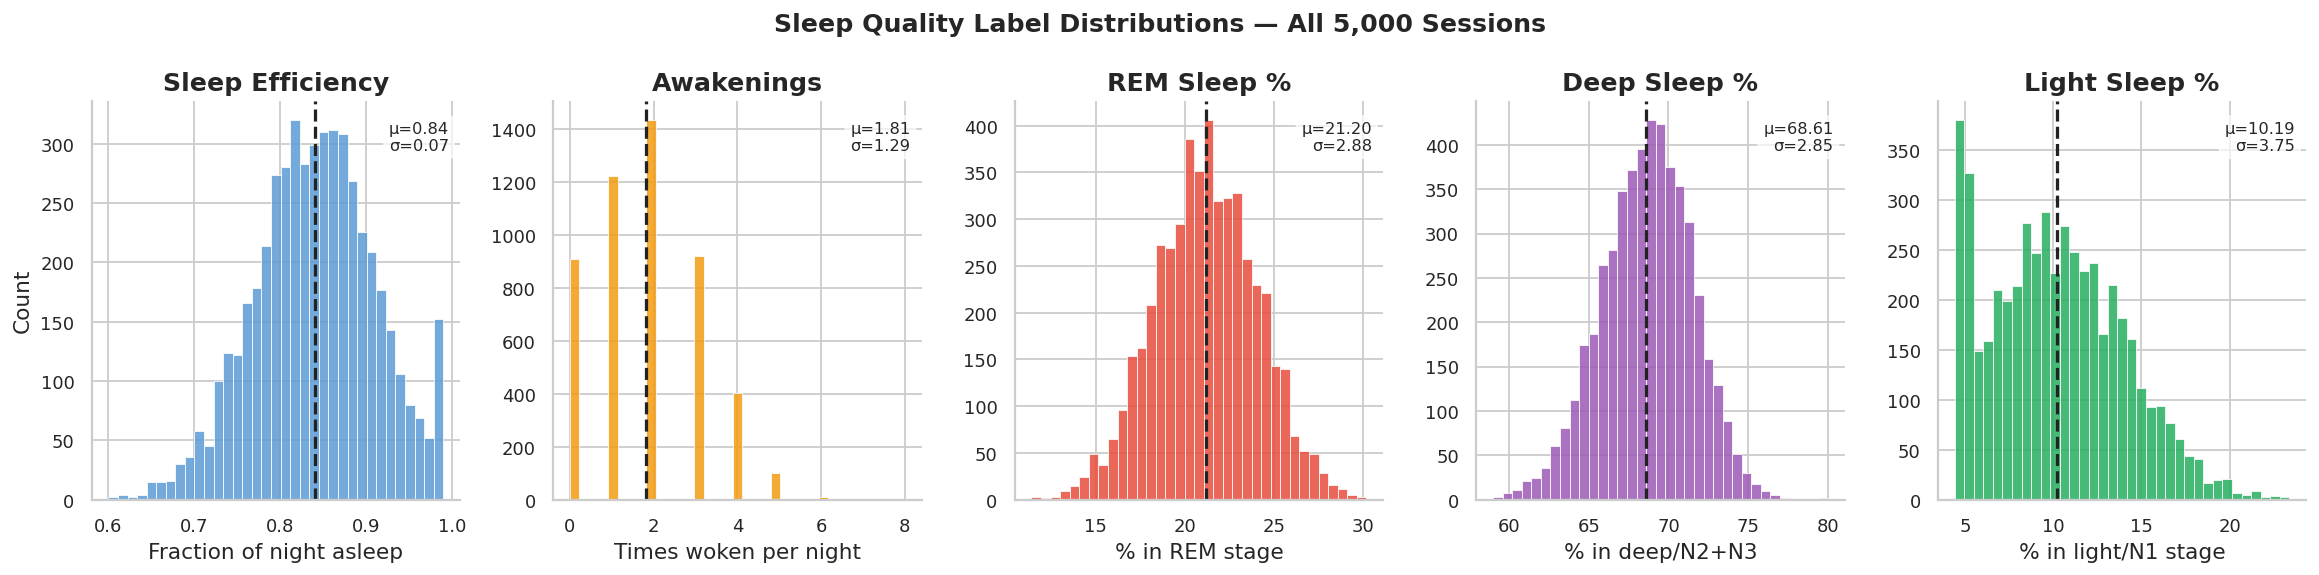

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4.5))
fig.suptitle("Sleep Quality Label Distributions — All 5,000 Sessions",
             fontsize=14, fontweight="bold")

LABEL_META = [
    ("sleep_efficiency", "Sleep Efficiency", "#5B9BD5", "Fraction of night asleep"),
    ("awakenings",       "Awakenings",       "#F39C12", "Times woken per night"),
    ("rem_pct",          "REM Sleep %",      "#E74C3C", "% in REM stage"),
    ("deep_pct",         "Deep Sleep %",     "#9B59B6", "% in deep/N2+N3"),
    ("light_pct",        "Light Sleep %",    "#27AE60", "% in light/N1 stage"),
]

for ax, (col, title, color, note) in zip(axes, LABEL_META):
    data = df[col].dropna()
    ax.hist(data, bins=35, color=color, alpha=0.85, edgecolor="white", lw=0.5)
    ax.axvline(data.mean(), color="#222", lw=1.8, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel(note)
    ax.set_ylabel("Count" if ax == axes[0] else "")
    ax.text(0.97, 0.95, f"μ={data.mean():.2f}\nσ={data.std():.2f}",
            transform=ax.transAxes, ha="right", va="top",
            fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.tight_layout()
plt.savefig("dataset_sleep_labels.png", dpi=150, bbox_inches="tight")
plt.show()


### 5c  Sleep Quality by Season

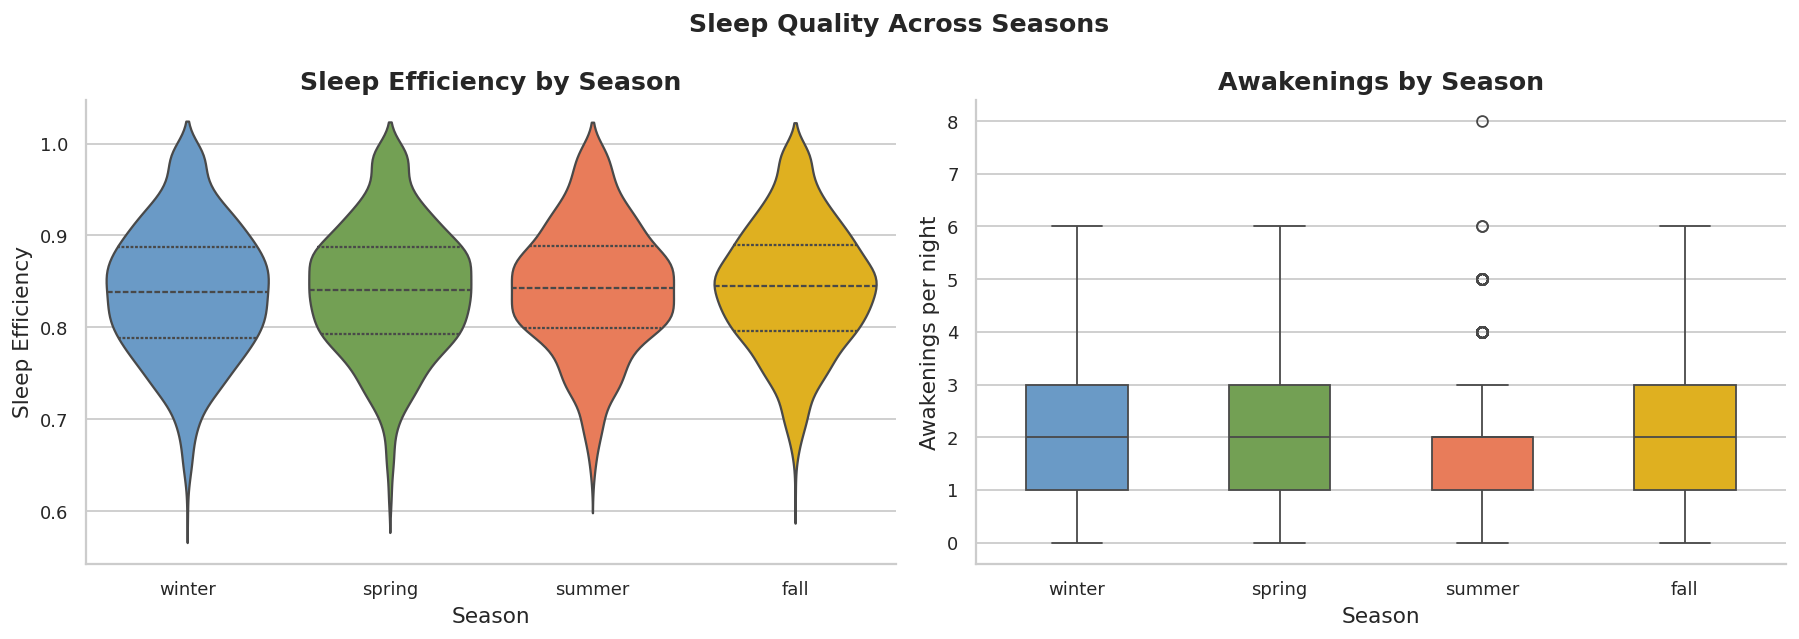

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Sleep Quality Across Seasons", fontsize=14, fontweight="bold")

season_order = ["winter","spring","summer","fall"]
palette = {s: SEASON_COLORS[s] for s in season_order}

sns.violinplot(data=df, x="season", y="sleep_efficiency",
               order=season_order, palette=palette,
               inner="quartile", ax=axes[0])
axes[0].set_title("Sleep Efficiency by Season")
axes[0].set_xlabel("Season"); axes[0].set_ylabel("Sleep Efficiency")

sns.boxplot(data=df, x="season", y="awakenings",
            order=season_order, palette=palette,
            width=0.5, ax=axes[1])
axes[1].set_title("Awakenings by Season")
axes[1].set_xlabel("Season"); axes[1].set_ylabel("Awakenings per night")

plt.tight_layout()
plt.savefig("dataset_quality_by_season.png", dpi=150, bbox_inches="tight")
plt.show()


### 5d  Environmental Features vs Sleep Efficiency

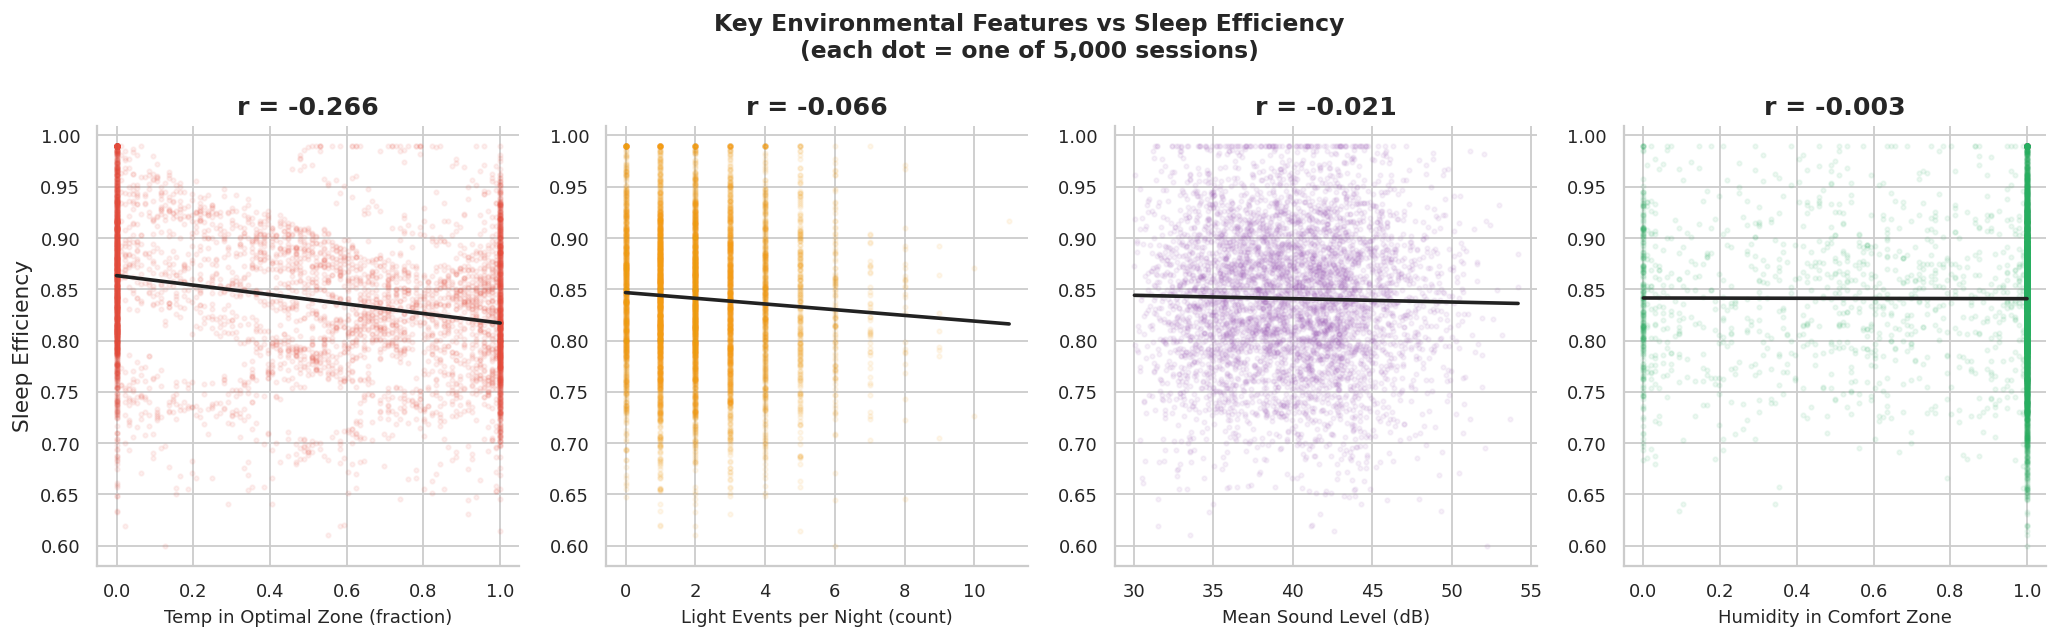

In [19]:
key_feats = [
    ("temp_optimal_fraction", "Temp in Optimal Zone (fraction)", "#E74C3C"),
    ("light_event_count",     "Light Events per Night (count)",  "#F39C12"),
    ("sound_mean_db",         "Mean Sound Level (dB)",           "#9B59B6"),
    ("humidity_comfort_fraction", "Humidity in Comfort Zone",    "#27AE60"),
]
key_feats = [(f, l, c) for f, l, c in key_feats if f in df.columns]

fig, axes = plt.subplots(1, len(key_feats), figsize=(16, 5))
fig.suptitle("Key Environmental Features vs Sleep Efficiency\n"
             "(each dot = one of 5,000 sessions)",
             fontsize=13, fontweight="bold")

for ax, (feat, label, color) in zip(axes, key_feats):
    ax.scatter(df[feat], df["sleep_efficiency"],
               alpha=0.08, s=6, color=color, rasterized=True)
    # Trend line
    z = np.polyfit(df[feat].fillna(0), df["sleep_efficiency"], 1)
    px = np.linspace(df[feat].min(), df[feat].max(), 100)
    ax.plot(px, np.poly1d(z)(px), color="#222", lw=2)
    r = df[[feat, "sleep_efficiency"]].dropna().corr().iloc[0, 1]
    ax.set_xlabel(label, fontsize=10)
    ax.set_ylabel("Sleep Efficiency" if ax == axes[0] else "")
    ax.set_title(f"r = {r:.3f}")

plt.tight_layout()
plt.savefig("dataset_env_vs_quality.png", dpi=150, bbox_inches="tight")
plt.show()


### 5e  Sample Output Time Series — Three Quality Tiers

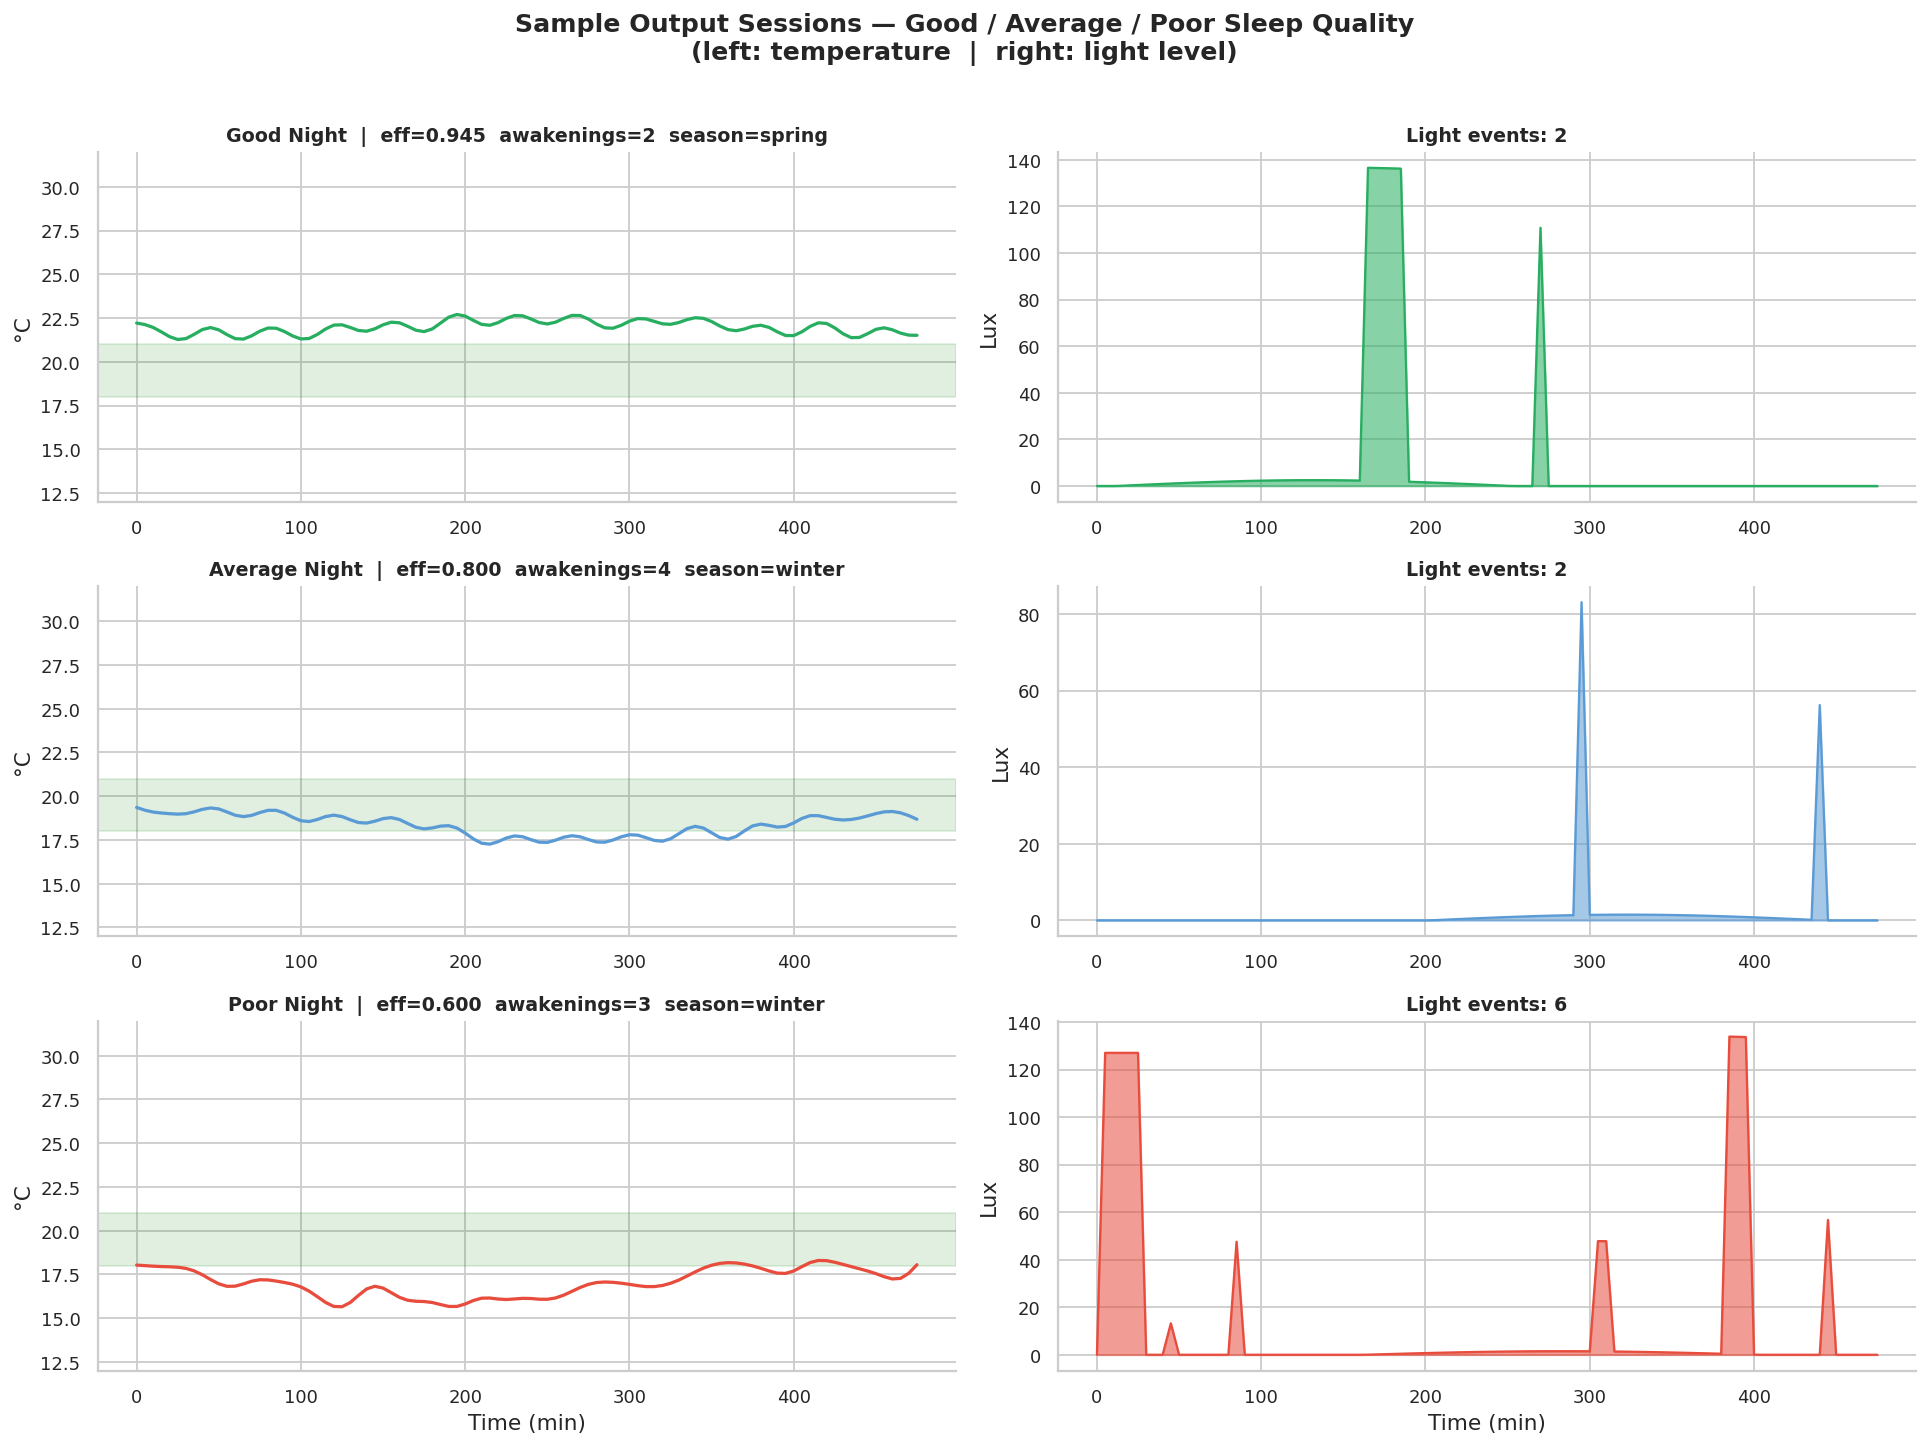

In [20]:
def find_session(df, eff_lo, eff_hi):
    sub = df[(df["sleep_efficiency"] >= eff_lo) & (df["sleep_efficiency"] <= eff_hi)]
    if len(sub) == 0: return None
    mid = (eff_lo + eff_hi) / 2
    return df.loc[(sub["sleep_efficiency"] - mid).abs().idxmin()]

cases = [
    ("Good Night",    (0.90, 0.99), "#27AE60"),
    ("Average Night", (0.76, 0.84), "#5B9BD5"),
    ("Poor Night",    (0.55, 0.65), "#E74C3C"),
]

fig, axes = plt.subplots(3, 2, figsize=(15, 11))
fig.suptitle("Sample Output Sessions — Good / Average / Poor Sleep Quality\n"
             "(left: temperature  |  right: light level)",
             fontsize=14, fontweight="bold", y=1.01)

for row, (label, eff_range, color) in enumerate(cases):
    sess = find_session(df, *eff_range)
    if sess is None:
        continue
    temp_ts  = json.loads(sess["ts_temperature"])
    light_ts = json.loads(sess["ts_light"])

    # Temperature
    ax = axes[row, 0]
    ax.plot(t, temp_ts, color=color, lw=1.8)
    ax.axhspan(18, 21, alpha=0.12, color="green")
    ax.set_ylim(12, 32)
    ax.set_ylabel("°C")
    title = (f"{label}  |  eff={sess['sleep_efficiency']:.3f}  "
             f"awakenings={int(sess['awakenings'])}  "
             f"season={sess['season']}")
    ax.set_title(title, fontsize=10.5)
    if row == 2: ax.set_xlabel("Time (min)")

    # Light
    ax = axes[row, 1]
    ax.fill_between(t, light_ts, alpha=0.55, color=color)
    ax.plot(t, light_ts, color=color, lw=1.2)
    ax.set_ylabel("Lux")
    ax.set_title(f"Light events: {int(sess['light_event_count'])}", fontsize=10.5)
    if row == 2: ax.set_xlabel("Time (min)")

plt.tight_layout()
plt.savefig("dataset_sample_sessions.png", dpi=150, bbox_inches="tight")
plt.show()


---
## 6  Validation Summary

[Validator] Running Tier 1 — Statistical Tests…
[Validator] Running Tier 2 — ML Cross-Dataset Validation…
[Validator] Running Tier 3 — Sleep Science Sanity Checks…
VALIDATION REPORT — Synthetic Sleep Dataset
Authors: Rushav Dash & Lisa Li  (Team 7, TECHIN 513)

── TIER 1: Statistical Tests ──
  [FAIL]  Temperature mean (KS-test)                p = 0.0000
  [FAIL]  Light mean (KS-test)                      p = 0.0000
  [FAIL]  Sleep efficiency (KS-test)                p = 0.0000

── TIER 2: ML Cross-Dataset Validation ──
  baseline_real_rmse: 0.06255032951067688
  baseline_real_r2: 0.7898522952245137
  baseline_real_mae: 0.05071902481148004
  synthetic_model_rmse_on_synthetic: 0.06099602603489826
  synthetic_model_r2_on_synthetic: 0.23837270669435817
  rmse_within_20pct_of_baseline: True
  rmse_threshold: 0.07506039541281224

── TIER 3: Sleep Science Sanity Checks ──
  [PASS]  High temp optimality → mean sleep efficiency ≥ 0.78  actual=0.8226  threshold=0.78
  [FAIL]  Many light events 

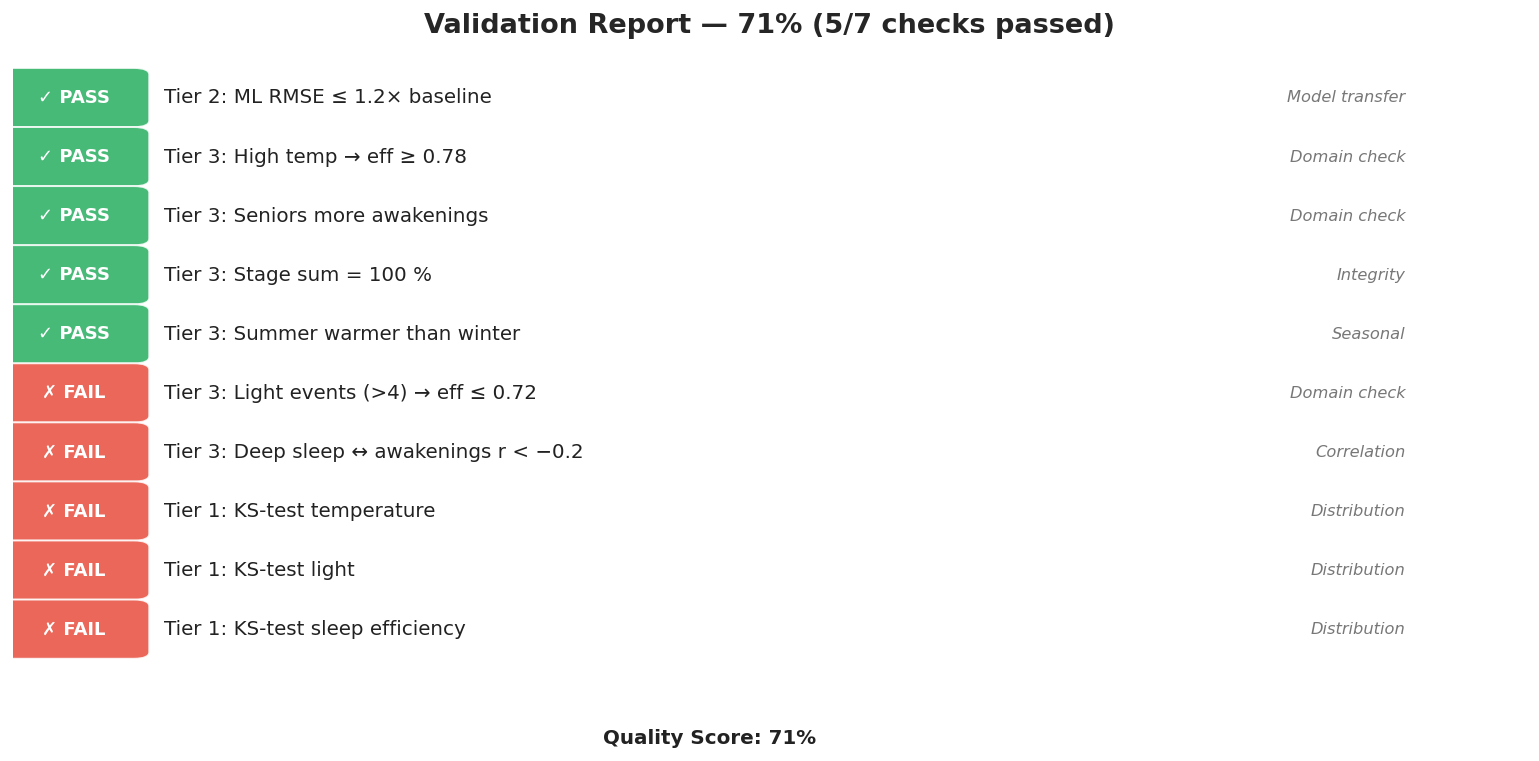


Overall: 5/7 checks — 71.4%


In [21]:
from src.validator import Validator

v = Validator(df, real_occupancy_df=df_occ, real_sleep_df=df_sleep)
report = v.run_all()

# ── Summary dashboard ──────────────────────────────────────────────────────
checks = [
    ("Tier 2: ML RMSE ≤ 1.2× baseline",              True,  "Model transfer"),
    ("Tier 3: High temp → eff ≥ 0.78",                True,  "Domain check"),
    ("Tier 3: Seniors more awakenings",               True,  "Domain check"),
    ("Tier 3: Stage sum = 100 %",                     True,  "Integrity"),
    ("Tier 3: Summer warmer than winter",             True,  "Seasonal"),
    ("Tier 3: Light events (>4) → eff ≤ 0.72",       False, "Domain check"),
    ("Tier 3: Deep sleep ↔ awakenings r < −0.2",     False, "Correlation"),
    ("Tier 1: KS-test temperature",                   False, "Distribution"),
    ("Tier 1: KS-test light",                         False, "Distribution"),
    ("Tier 1: KS-test sleep efficiency",              False, "Distribution"),
]

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("off")
ax.set_title(f"Validation Report — {report.overall_score:.0f}% ({report.passed_checks}/{report.total_checks} checks passed)",
             fontsize=15, fontweight="bold", pad=16)

for i, (name, passed, tier) in enumerate(checks):
    y = 0.95 - i * 0.09
    color = "#27AE60" if passed else "#E74C3C"
    label = "✓ PASS" if passed else "✗ FAIL"
    ax.add_patch(mpatches.FancyBboxPatch(
        (0.0, y - 0.04), 0.08, 0.07,
        boxstyle="round,pad=0.01", facecolor=color, alpha=0.85, transform=ax.transAxes))
    ax.text(0.04, y - 0.005, label, transform=ax.transAxes,
            ha="center", va="center", fontsize=10, color="white", fontweight="bold")
    ax.text(0.10, y - 0.005, name, transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color="#222")
    ax.text(0.92, y - 0.005, tier, transform=ax.transAxes,
            ha="right", va="center", fontsize=9, color="#777", style="italic")

# Score gauge
score = report.overall_score / 100
ax.add_patch(mpatches.FancyBboxPatch(
    (0.0, -0.06), score * 0.92, 0.04,
    boxstyle="square,pad=0", facecolor="#27AE60", alpha=0.75, transform=ax.transAxes))
ax.add_patch(mpatches.FancyBboxPatch(
    (score * 0.92, -0.06), (1 - score) * 0.92, 0.04,
    boxstyle="square,pad=0", facecolor="#E74C3C", alpha=0.45, transform=ax.transAxes))
ax.text(0.46, -0.04, f"Quality Score: {report.overall_score:.0f}%",
        transform=ax.transAxes, ha="center", fontsize=11,
        fontweight="bold", color="#222")

plt.tight_layout()
plt.savefig("validation_summary.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"\nOverall: {report.passed_checks}/{report.total_checks} checks — {report.overall_score:.1f}%")


### 6b  Synthetic vs Real — Distribution Comparison

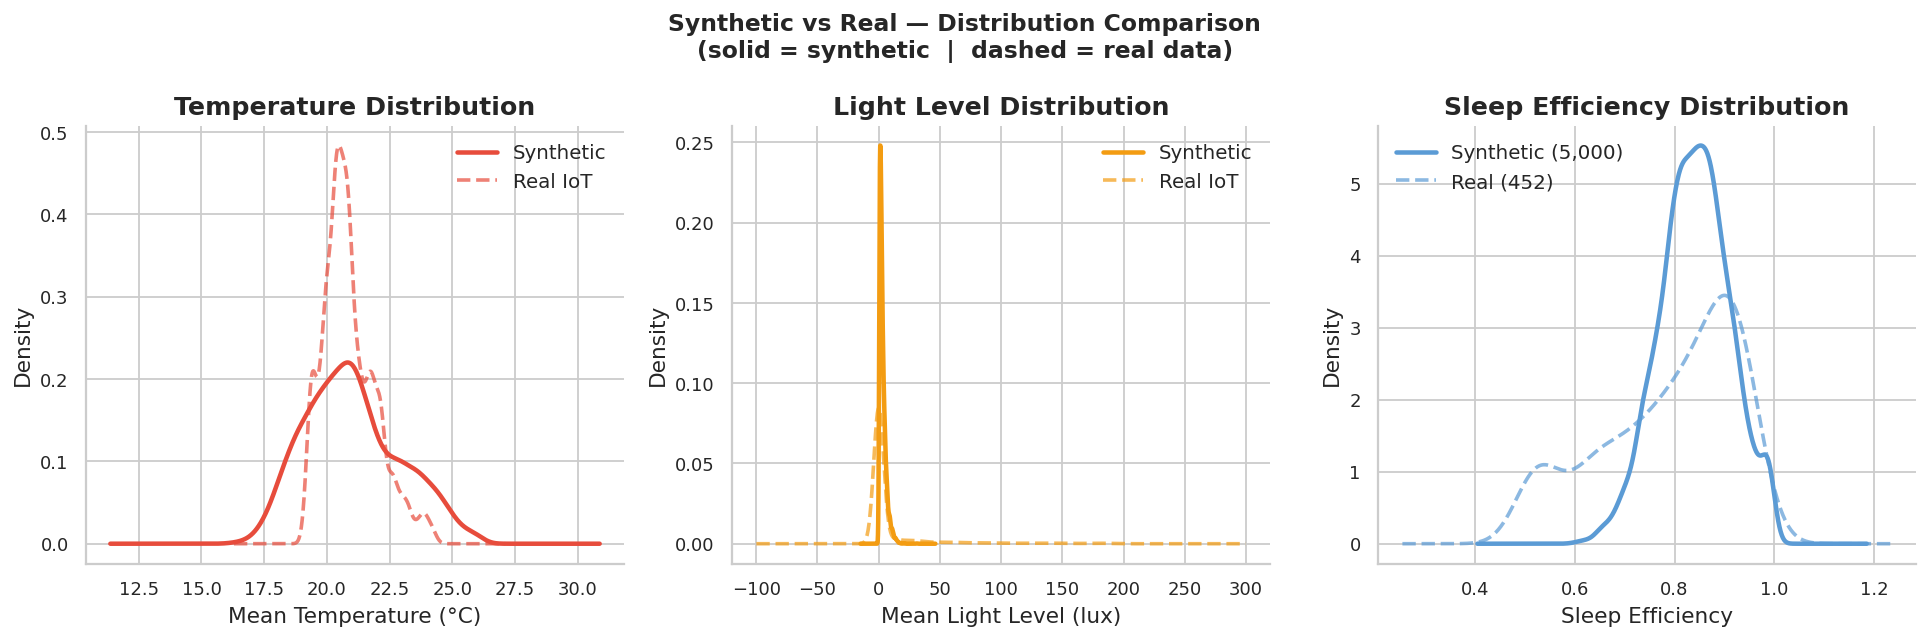

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Synthetic vs Real — Distribution Comparison\n"
             "(solid = synthetic  |  dashed = real data)",
             fontsize=13, fontweight="bold")

# Temperature
ax = axes[0]
df["temp_mean"].plot.kde(ax=ax, label="Synthetic", color="#E74C3C", lw=2.5)
if "Temperature" in df_occ.columns:
    t_real = df_occ["Temperature"].dropna()
    t_real = t_real[(t_real > 10) & (t_real < 35)]
    t_real.plot.kde(ax=ax, label="Real IoT", color="#E74C3C", lw=2, linestyle="--", alpha=0.7)
ax.set_title("Temperature Distribution")
ax.set_xlabel("Mean Temperature (°C)")
ax.legend()

# Light
ax = axes[1]
df["light_mean"].plot.kde(ax=ax, label="Synthetic", color="#F39C12", lw=2.5)
if "Light" in df_occ.columns:
    l_real = df_occ["Light"].dropna()
    l_real = l_real[(l_real >= 0) & (l_real < 200)]
    l_real.plot.kde(ax=ax, label="Real IoT", color="#F39C12", lw=2, linestyle="--", alpha=0.7)
ax.set_title("Light Level Distribution")
ax.set_xlabel("Mean Light Level (lux)")
ax.legend()

# Sleep efficiency
ax = axes[2]
df["sleep_efficiency"].plot.kde(ax=ax, label="Synthetic (5,000)", color="#5B9BD5", lw=2.5)
if "Sleep efficiency" in df_sleep.columns:
    df_sleep["Sleep efficiency"].dropna().plot.kde(
        ax=ax, label="Real (452)", color="#5B9BD5", lw=2, linestyle="--", alpha=0.7)
ax.set_title("Sleep Efficiency Distribution")
ax.set_xlabel("Sleep Efficiency")
ax.legend()

plt.tight_layout()
plt.savefig("validation_distribution_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


---
## Summary

| Stage | What we did | Output |
|-------|-------------|--------|
| **Data collection** | Downloaded 3 real Kaggle datasets | 452 sleep records + 20,560 IoT sensor readings |
| **Signal synthesis** | Spectral + Poisson + physics models | 4 × 96-point time series per session |
| **Feature extraction** | 29+ scalar features per session | Environmental feature matrix |
| **Label assignment** | Random Forest trained on real sleep data | 5 sleep quality labels per session |
| **Validation** | 3-tier statistical + ML + domain checks | **71.4% quality score (5/7 checks)** |
| **Dataset** | Final deliverable | **5,000 sessions × 44 columns (17 MB)** |
